# Development and Nonlinear Buckling Analysis of a CRM-like Box Beam

In all our notebooks so far we have used a box beam geometry with a length-based aspect ratio $AR=l/w=4.5$, so that the aspect ratio based on twice the length, $2l/w$, was equal to the aspect ratio of the CRM wing, that is to say $9$. However, the CRM wingbox is much more slender than the wing itself. For this reason, in this notebook we are going to define a box beam geometry more similar to the one of the CRM wingbox, and we'll investigate its nonlinear buckling behavior.

* [Geometry definition](#geometry)
* [Setup of the numerical model](#numerical-model)
* [Mesh convergence study](#mesh-convergence)
* [Nonlinear analysis: mesh convergence verification](#mesh-verification)
* [Nonlinear analysis: sensitivity of nonlinear analysis parameters](#nonlinear-analysis-parameters)
    * [Error function](#error-function)
    * [Convergence tolerance](#convergence-tolerance)
    * [Initial load increment](#ninc)
    * [Desired number of iteration](#desiter)
    * [Minimum allowable arc-length adjustment ratio](#minalr)
    * [Maximum allowable arc-length adjustment ratio](#maxalr)
* [3D equilibrium diagram](#equilibrium-diagram)
* [Conclusions](#conclusions)

## Geometry definition <a name="geometry"></a>

***

We consider the same kind of straight box beam geometry of our previous notebooks, as shown below.

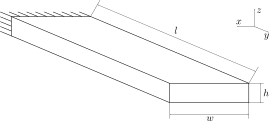

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '18_BoxBeamGeometry.svg'))

As we can observe in the figure below, adapted from [Taylor & Hunsaker (2021)](https://arc.aiaa.org/doi/abs/10.2514/6.2021-1591), the CRM wingbox is a much more slender object than the wing itself. Consequently, using a straight box beam with a two-lengths-based aspect ratio equal to the aspect ratio of the CRM wing, $2l/w=9$, does not lead to a structure similar to the CRM wingbox.

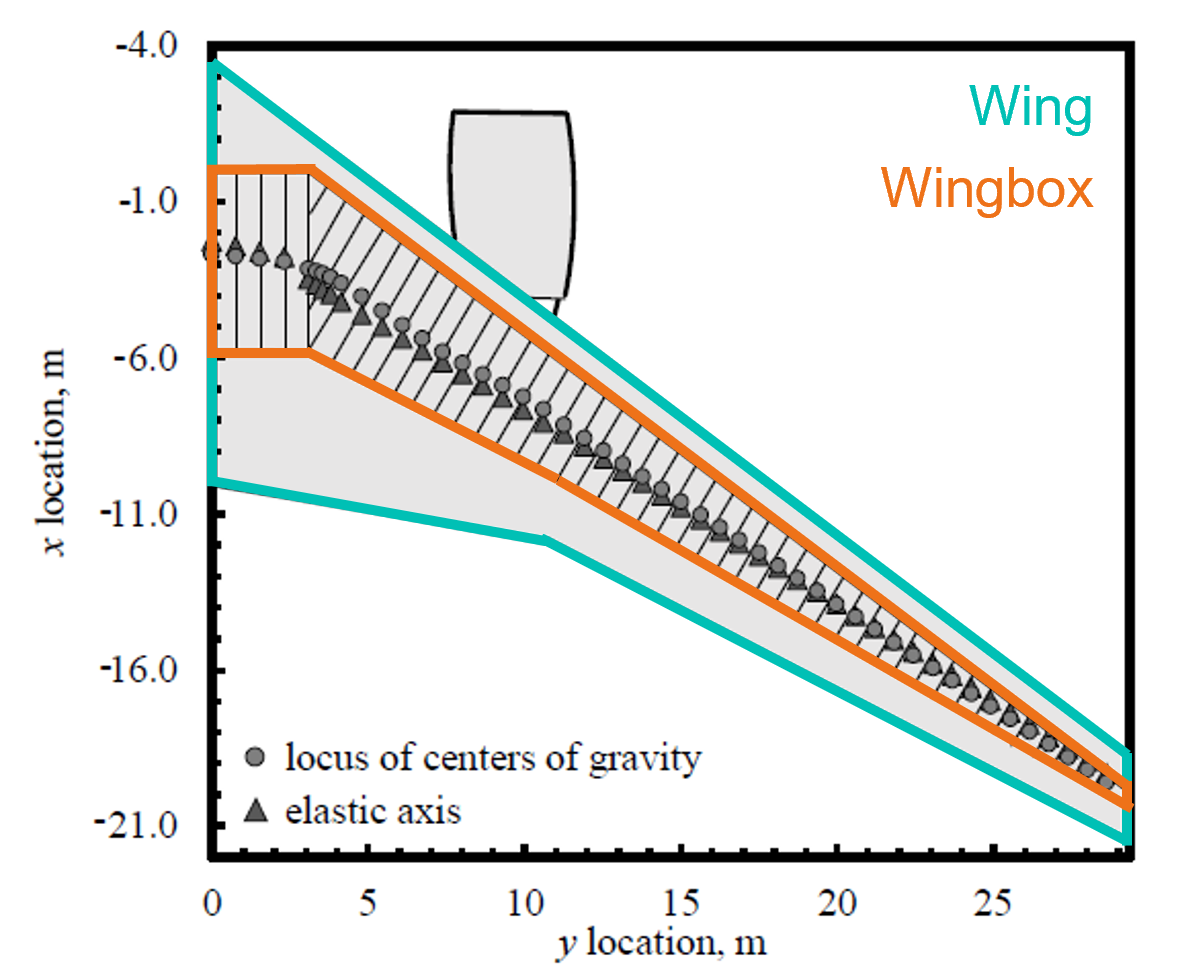

In [2]:
from IPython.display import Image  # class to display images
import os  # module with miscellaneous operating system interfaces

Image(filename=os.path.join('resources', '18_CRM.png'))

For this reason, we want to derive a closer straight box beam approximation of the CRM wingbox. In order to do that, we need to calculate the values of length $l$, width $w$ and height $h$ so that they represent the closest geometric approximation of the CRM wingbox semi-span, width and height, respectively. Of these quantities, the last two are variable along the span, while the value of the span is fixed. As a consequence, we can take the lenght of our box beam equal to be equal to half the span of the CRM wingbox, $b_{wb}$, which in turn is equal to the CRM wingspan:

$$l=b_{wb}/2.$$

In [3]:
b_wb = 58.76  # CRM wingspan [m]
l = b_wb/2  # [m]
print(f"Box beam length: {l:.2f} m")

Box beam length: 29.38 m


Since both the width $w_{wb}(y)$ and the height $h_{wb}(y)$ of the CRM wingbox vary along the span, we need to find a reference value for each to use for our straight box beam model. We can find a reference value of the wingbox width by dividing the wingspan by the wingbox aspect ratio $AR_{wb}$:

$$w=b_{wb}/AR_{wb}.$$

How can we find the the aspect ratio of the CRM wingbox? Similarly to the aspect ratio of a wing, we can define the aspect ratio of the wingbox as the ratio between the square of its span and its planform area $S_{wb}$:

$$AR_{wb}=\frac{\left(b_{wb}\right)^2}{S_{wb}},$$

where we can calculate the latter as the integral of the width along the semi-span:

$$S_{wb}=2\int_0^{b_{wb}/2} w_{wb}(y)\mathrm{d}y.$$

We can infer $w_{wb}(y)$ from the wingbox data reported by [Taylor & Hunsaker (2021)](https://arc.aiaa.org/doi/abs/10.2514/6.2021-1591). Below we codify the spanwise distribution of chord, front and rear spar $x$-coordinate and height of the CRM reported by the authors. In the paper, the data of the two spars is given at each rib station along the span of the wing. These stations include the ribs next to the kink of the wingbox, where a few ribs intersect the last rib aligned with the fuselage, as it can be observed in the figure above. Here, for the purpose of defining our geometry, we remove the rear spar data associated to the ribs that are not connected to the rear spar.

In [4]:
import numpy as np

# Chord distribution along the span
chord = np.array([[0.00, 13.6161],  # xi, chord [m]
                  [0.10, 11.8976],
                  [0.15, 11.0384],
                  [0.20, 10.1790],
                  [0.25, 9.3197],
                  [0.30, 8.4604],
                  [0.35, 7.6010],
                  [0.37, 7.2573],
                  [0.40, 7.0416],
                  [0.45, 6.6821],
                  [0.50, 6.3226],
                  [0.55, 5.9631],
                  [0.60, 5.6035],
                  [0.65, 5.2440],
                  [0.70, 4.8845],
                  [0.75, 4.5250],
                  [0.80, 4.1654],
                  [0.85, 3.8059],
                  [0.90, 3.4464],
                  [0.95, 3.0869],
                  [1.00, 2.7274]])

# Distribution of the front spar nondimensional x-coordinate and height along the span
front_spar = np.array([[0.0000, 0.2524, 2.0371],  # xi, x/c, h [mm]
                       [0.0264, 0.2178, 1.8564],
                       [0.0527, 0.1806, 1.6504],
                       [0.0791, 0.1407, 1.4163],
                       [0.1055, 0.0978, 1.1415],
                       [0.1258, 0.1016, 1.0797],
                       [0.1462, 0.1056, 1.0193],
                       [0.1665, 0.1089, 0.9603],
                       [0.1868, 0.1123, 0.9049],
                       [0.2072, 0.1157, 0.8540],
                       [0.2275, 0.1193, 0.8072],
                       [0.2478, 0.1232, 0.7642],
                       [0.2681, 0.1274, 0.7250],
                       [0.2885, 0.1319, 0.6893],
                       [0.3088, 0.1369, 0.6568],
                       [0.3291, 0.1422, 0.6273],
                       [0.3495, 0.1481, 0.6009],
                       [0.3698, 0.1545, 0.5777],
                       [0.3901, 0.1570, 0.5639],
                       [0.4104, 0.1596, 0.5514],
                       [0.4308, 0.1579, 0.5398],
                       [0.4511, 0.1650, 0.5287],
                       [0.4714, 0.1680, 0.5174],
                       [0.4918, 0.1710, 0.5064],
                       [0.5121, 0.1742, 0.4967],
                       [0.5324, 0.1775, 0.4880],
                       [0.5528, 0.1810, 0.4797],
                       [0.5731, 0.1847, 0.4715],
                       [0.5934, 0.1886, 0.4634],
                       [0.6137, 0.1927, 0.4553],
                       [0.6341, 0.1970, 0.4472],
                       [0.6544, 0.2015, 0.4385],
                       [0.6747, 0.2063, 0.4291],
                       [0.6951, 0.2114, 0.4194],
                       [0.7154, 0.2168, 0.4098],
                       [0.7357, 0.2226, 0.4002],
                       [0.7560, 0.2287, 0.3904],
                       [0.7764, 0.2353, 0.3805],
                       [0.7967, 0.2423, 0.3703],
                       [0.8170, 0.2498, 0.3599],
                       [0.8374, 0.2579, 0.3492],
                       [0.8577, 0.2666, 0.3382],
                       [0.8780, 0.2760, 0.3269],
                       [0.8984, 0.2862, 0.3154],
                       [0.9187, 0.2973, 0.3038],
                       [0.9390, 0.3094, 0.2922],
                       [0.9593, 0.3209, 0.2808],
                       [0.9797, 0.3373, 0.2691],
                       [1.0000, 0.3536, 0.2560]])

# Distribution of the rear spar nondimensional x-coordinate and height along the span
rear_spar = np.array([[0.0000, 0.6936, 1.2970],  # xi, x_te/c, h_te [mm]
                      [0.0264, 0.6730, 1.2942],
                      [0.0527, 0.6509, 1.2858],
                      [0.0791, 0.6272, 1.2711],
                      [0.1055, 0.6019, 1.2473],
                      [0.1084, 0.6026, 1.2320],
                      [0.1310, 0.6090, 1.1220],
                      [0.1535, 0.6157, 1.0316],
                      [0.1760, 0.6219, 0.9573],
                      [0.1986, 0.6286, 0.8916],
                      [0.2211, 0.6356, 0.8320],
                      [0.2436, 0.6432, 0.7777],
                      [0.2662, 0.6515, 0.7271],
                      [0.2887, 0.6607, 0.6788],
                      [0.3112, 0.6707, 0.6310],
                      [0.3338, 0.6818, 0.5817],
                      [0.3563, 0.6941, 0.5303],
                      [0.3786, 0.7016, 0.4903],
                      [0.4004, 0.7002, 0.4761],
                      [0.4223, 0.6988, 0.4635],
                      [0.4441, 0.6972, 0.4514],
                      [0.4660, 0.6957, 0.4400],
                      [0.4878, 0.6941, 0.4284],
                      [0.5096, 0.6924, 0.4171],
                      [0.5315, 0.6906, 0.4065],
                      [0.5533, 0.6888, 0.3964],
                      [0.5752, 0.6868, 0.3860],
                      [0.5970, 0.6848, 0.3755],
                      [0.6189, 0.6826, 0.3653],
                      [0.6407, 0.6804, 0.3555],
                      [0.6626, 0.6779, 0.3460],
                      [0.6844, 0.6754, 0.3370],
                      [0.7063, 0.6726, 0.3284],
                      [0.7281, 0.6697, 0.3199],
                      [0.7500, 0.6666, 0.3109],
                      [0.7718, 0.6633, 0.3005],
                      [0.7936, 0.6597, 0.2894],
                      [0.8155, 0.6558, 0.2786],
                      [0.8373, 0.6516, 0.2682],
                      [0.8592, 0.6470, 0.2583],
                      [0.8810, 0.6420, 0.2487],
                      [0.9029, 0.6365, 0.2386],
                      [0.9247, 0.6303, 0.2276],
                      [0.9466, 0.6236, 0.2167],
                      [0.9684, 0.6163, 0.2062],
                      [1.0000, 0.6039, 0.1890]])

Considering how the distribution of the $x$-coordinates of the front and rear spars is provided, we can interpolate the coordinates to a common set of spanwise stations and calculate the wingbox width $w_{wb}(y)$ as the difference between the rear and front spar coordinates, $x_{rear}(y)-x_{front}(y)$.

Let's calculate $S_{wb}$, $AR_{wb}$, $w$ and print the results.

In [5]:
x_front = front_spar[:, 1] * np.interp(front_spar[:, 0], chord[:, 0], chord[:, 1])  # calculate x-coordinate of front spar --> x/c(y)*c(y) - chord values are interpolated to the spanwise station of the spar
x_rear = rear_spar[:, 1] * np.interp(rear_spar[:, 0], chord[:, 0], chord[:, 1])  # calculate x-coordinate of rear spar
xi = np.unique(np.concatenate([front_spar[:, 0], rear_spar[:, 0]]))  # combine spanwise stations of front and rear spar
w_wb = np.interp(xi, rear_spar[:, 0], x_rear) - np.interp(xi, front_spar[:, 0], x_front)  # calculate wingbox width at the combined spanwise stations
S_wb = 2*(np.trapz(w_wb, xi*b_wb/2))  # calculate the wingbox planform area
AR_wb = b_wb**2/S_wb  # calculate the wingbox aspect ratio
w = b_wb/AR_wb  # calculate the wingbox reference width
print(f"""
Wingbox planform area: {S_wb:.0f} m\u00b2
Wingbox aspect ratio: {AR_wb:.1f}
Equivalent box beam width: {w:.2f} m""")


Wingbox planform area: 200 m²
Wingbox aspect ratio: 17.2
Equivalent box beam width: 3.41 m


With the length and the width of our new box beam, we can also calculate its length-based aspect ratio, $l/w$, and compare it with the value of our previous box beam.

In [6]:
AR = l/w
print(f'Box beam aspect ratio: {AR:.1f}')

Box beam aspect ratio: 8.6


We have found a value that is almost double than the one of our previous box beam (4.5)! This gives us a feeling of how the CRM wingbox is a much more slender structure than the one we have been using so far.

What about the equivalent box beam height? The idea here is that we can obtain a reference height of the CRM wingbox by dividing the wingbox volume $V_{wb}$ by the planform area:

$$h=\frac{V_{wb}}{S_{wb}}.$$

And how can we calculate the volume of the wingbox? Well, we can think of it as the integral of the cross-sectional area of the wingbox along the semi-span. In turn, the cross-sectional area at each spanwise station can be approximated with the area of the trapezium formed by connecting the two spars:

$$V_{wb}=2\int_0^{b_{wb}/2}\frac{h_{front}(y)+h_{rear}(y)}{2}w_{wb}(y)\mathrm{d}y,$$

where $h_{front}(y)$ and $h_{rear}(y)$ are the spanwise distribution of the front and rear spar height, respectively.

In [7]:

h_front = np.interp(xi, front_spar[:, 0], front_spar[:, 2])  # interpolate front spar height to the combined spanwise stations
h_rear = np.interp(xi, rear_spar[:, 0], rear_spar[:, 2])  # interpolate rear spar height to the combined spanwise stations
cross_sectional_area = (h_front+h_rear)/2*w_wb
V_wb = 2*(np.trapz(cross_sectional_area, xi*b_wb/2))
h = V_wb/S_wb
print(f"""
Wingbox volume: {V_wb:.0f} m\u00b3
Equivalent box beam height: {h:.2f} m""")


Wingbox volume: 154 m³
Equivalent box beam height: 0.77 m


We can also calculate the nondimensional height $h/w$ of our new box beam and compare it with the old one.

In [8]:
nondimensional_height = h/w
print(f"Nondimensional height: {nondimensional_height:.2f}")

Nondimensional height: 0.23


This value is actually not that far from the one of our previous box beam, meaning that the cross-sectional properties are not going to be much different.

## Setup of the numerical model <a name="numerical-model"></a>

***

Having found the length, width and height of our new box beam, we now need to define the wall thickness and the internal reinforcements. We round the found parameters to the second decimal place and we convert the quantities from meters to millimiters. Then we set the wall thickness to $1/100$ of the height in order to obtain a thin-walled structure. The same thickness will be used for all elements of the structure.

In [9]:
l = l*1e3  # [mm]
w = np.round(w, 2)*1e3  # [mm]
h = np.round(h, 2)*1e3  # [mm]
non_dimensional_thickness = 1/100  # t/h
t = h*non_dimensional_thickness  # wall thickness [mm]
print(f"Wall thickness: {t:.2f} mm")

Wall thickness: 7.70 mm


The prescribed value of wall thickness is in the lower range of the skin thicknesses obtained by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603) for the uCRM-9.

Next we define the internal structure. Since we want to keep the model simple, we are going to use only two stiffeners for each skin, similarly to our [old box beam](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb). The idea here is to have a structure that retains the essential features of a wingbox in terms of buckling behavior, and we consider this approach satisfactory. We define the $x$-coordinates of the stiffeners based on their prescribed number and then we set their height equal to $1/10$ of the box beam height.

In [10]:
# Find stiffeners location based on prescribed number of stiffeners
no_stiffeners = 2
stiffeners_x_locations = np.linspace(0, w, no_stiffeners + 2)[1:-1]

# Define stiffeners height
stiffeners_height = h/10

# Print info
np.set_printoptions(precision=2)
print('Stiffeners x-coordinate [m]:')
print(stiffeners_x_locations/1e3)
print(f'Stiffeners height: {stiffeners_height:.2f} mm')

Stiffeners x-coordinate [m]:
[1.14 2.27]
Stiffeners height: 77.00 mm


We note that the prescribed value of stiffeners height is sligthly above the range obtained by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603) for the uCRM. However, this should not be of great importance, as in our case there is a substantial difference both in the arrangement of the reinforcements and in the analsysis method.

To define the ribs' spacing, we use a similar approach to our [old box beam](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb). Considering the [analytical results of a thin plate under uniaxial compression](03_Equilibrium_Diagram_of_a_Thin_Plate_under_Uniaxial_Compression.ipynb#problem-definition) as a first order approximation, we multiply the stiffeners spacing by $1.4$. Then, we define the number of ribs and their $y$-coordinates based on the prescribed spacing.

Our aim is to have the highest theoretical linear buckling load of the rib-stiffener bay for a buckling mode with one or two half waves. Even higher buckling loads can be obtained using an aspect ratio of the rib-stiffener bay smaller then 1, but that implies the use of a large number of ribs. This is typically avoided in aircraft design as it leads to a significant increase in weight.

We note that our approach is not very accurate, as the rib-stiffener bays composing a reinforced plate behave differently from a simply supported plate of the same dimensions. However, here we only want to obtain a vaguely reasonable value of the ribs' spacing, and we consider this approach satisfactory.

In [11]:
# Find ribs location based on prescribed spacing
stiffeners_spacing = w/(no_stiffeners + 1)
ribs_spacing = stiffeners_spacing*1.4
no_ribs = round(l/ribs_spacing) + 1
ribs_y_locations = np.linspace(0, l, no_ribs)

# Print info
print(f"Number of ribs: {no_ribs:d}")
print("Ribs y-coordinate [m]:")
print(ribs_y_locations/1e3)

Number of ribs: 19
Ribs y-coordinate [m]:
[ 0.    1.63  3.26  4.9   6.53  8.16  9.79 11.43 13.06 14.69 16.32 17.95
 19.59 21.22 22.85 24.48 26.12 27.75 29.38]


The last step before creating the mesh is to define the material properties of the structure. We use the same properties of [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603).

In [12]:
rho = 2780e-12  # density [tons/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

Now we want to create an example mesh to show how our new box beam looks like. We select an element length equal to half the height of the box beam and we call the function `mesh_stiffened_box_beam_with_pyvista` from the `box_beam_utils` module to generate the mesh. This returns a `PolyData` object, represents the mesh, and we can visualize it by calling the `plot` method.

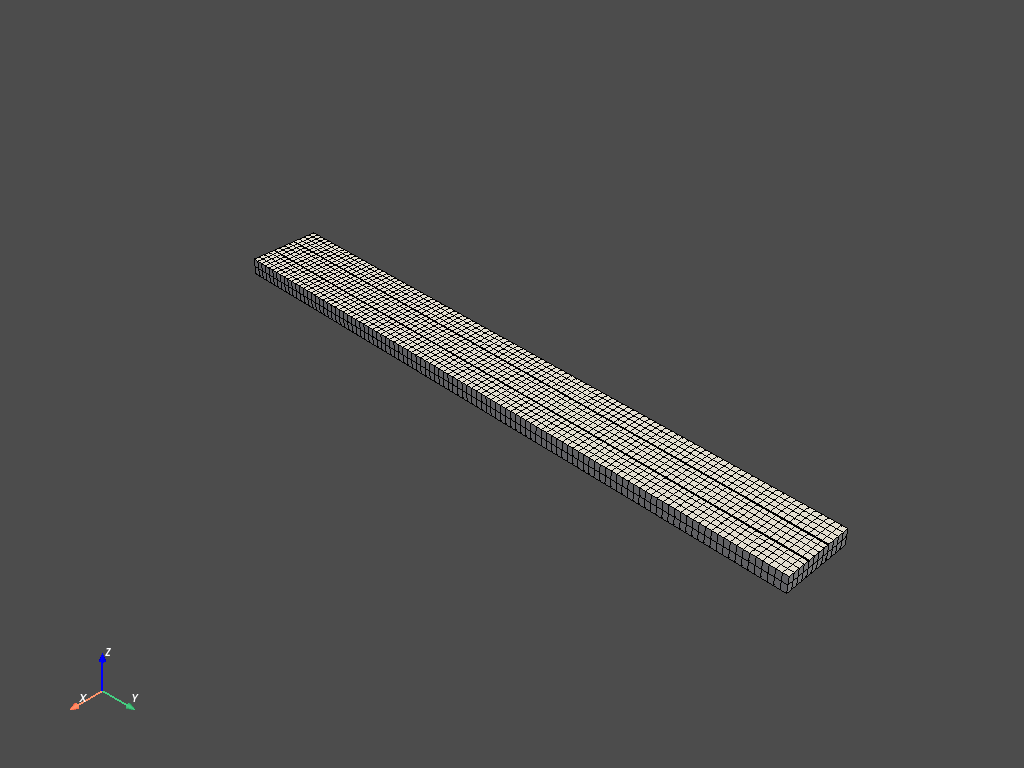

In [13]:
from resources import box_beam_utils

element_length = h/2  # [mm]
example_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h,
                                                                   ribs_y_coordinates=ribs_y_locations,
                                                                   stiffeners_x_coordinates=stiffeners_x_locations,
                                                                   stiffeners_height=stiffeners_height,
                                                                   element_length=element_length)
example_mesh.plot(show_edges=True, jupyter_backend='static')

Successively, we need to create a base bdf input, which we are going to complete for each analysis that we want to perform. For this purpose we use the function `create_base_bdf_input` from the `box_beam_utils` module. This function returns a `BDF` object, and we print a summary of its cards with the `get_bdf_stats` method.

In [14]:
nodes_xyz_array = example_mesh.points  # Nx3 array with the xyz coordinates of the nodes
nodes_connectivity_matrix = example_mesh.faces.reshape(-1, 5)[:, 1:]  # Nx4 array with the indices of the nodes defining each element in each row
example_bdf_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho,
                                                         shell_thickness=t, nodes_xyz_array=nodes_xyz_array,
                                                         nodes_connectivity_matrix=nodes_connectivity_matrix)
print(example_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 4133

bdf.elements: 0
  CQUAD4   : 4344

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Finally, it's time to define our load. Analogously to our previous notebooks, we are going to consider a concentrated bending load applied at the tip, as shown below. We define the function `apply_tip_concentrated_load` that performs the following steps:

- add a master node at the center of the tip section;
- connect the master node to the nodes on the edge of the tip rib with a `RBE3` element, which defines the motion at a reference grid point as the weighted average of the motions at a set of other grid points;
- apply a unitary vertical force at the master point with a `FORCE` card.

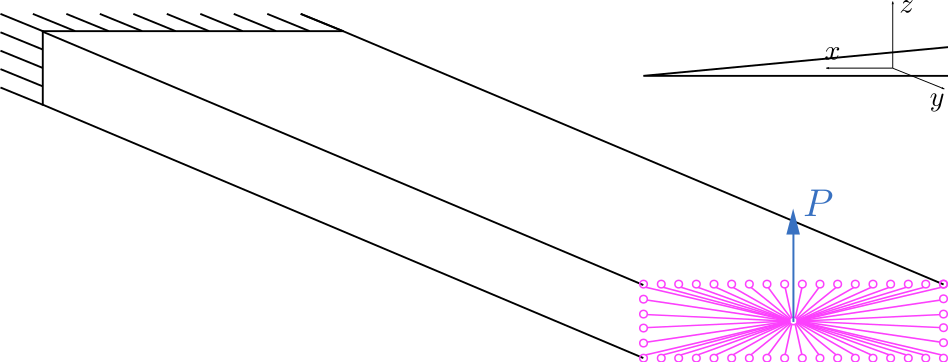

In [15]:
SVG(filename=os.path.join('resources', '08_BoxBeamConcentratedLoad.svg'))

In [16]:
from resources import pynastran_utils

def apply_tip_concentrated_load(bdf_input, force_id):
    # Add master node at the center of the tip section
    master_node_id = len(bdf_input.nodes) + 1
    bdf_input.add_grid(master_node_id, [w/2, l, 0.])
    # Find id of the nodes on the edge of the tip rib
    tolerance = stiffeners_height/100  # we define a geometric tolerance to find the nodes equal to 1/100 of the stiffener height
    tip_edge_nodes_ids = [nid for nid in bdf_input.nodes if (np.abs(bdf_input.nodes[nid].xyz[1] - l) < tolerance) &  # find nodes on the tip rib
                          (np.abs((bdf_input.nodes[nid].xyz[0]) < tolerance) |  # find nodes on the front spar
                           (np.abs(bdf_input.nodes[nid].xyz[0] - w) < tolerance) |  # find nodes on the rear spar
                           (np.abs(bdf_input.nodes[nid].xyz[2] - h/2) < tolerance) |  # find nodes on the top skin
                           (np.abs(bdf_input.nodes[nid].xyz[2] + h/2) < tolerance))]  # find nodes on the bottom skin
    # Add RBE3 to connect master node with edge nodes of tip rib
    rbe3_eid = len(bdf_input.elements) + 1
    bdf_input.add_rbe3(eid=rbe3_eid, refgrid=master_node_id, refc='123456', weights=[1.]*len(tip_edge_nodes_ids),
                       comps=['123456']*len(tip_edge_nodes_ids), Gijs=tip_edge_nodes_ids)
    # Add concentrated force
    force_direction = [0., 0., 1.]
    pynastran_utils.add_unitary_force(bdf_object=bdf_input, nodes_ids=[master_node_id], set_id=force_id,
                                      direction_vector=force_direction)
    # Return id of master node
    return master_node_id

Now we have all the ingredients to move on to the analysis of our new box beam model.

## Mesh convergence study <a name="mesh-convergence"></a>

***

Analogously to what we did for our old box beam models, we need perform a mesh convergence study to establish an appropriate mesh size for our analyses. For this reason, we define 10 different linear sizes of the plate elements, evenly spaced on a log scale between half the height of the box beam and 1/8 of the stiffners' height. For each plate element size, we generate a mesh, create the base `BDF` ojbect, apply the load, and run SOL 105 by calling the function `run_sol_105_buckling_analysis` from the `pynastran_utils` module. For each analysis we store the number of degrees of freedom of the model and the calculated critical buckling load to monitor how the latter changes with the former.

In [17]:
%matplotlib widget

import matplotlib.pyplot as plt  # plotting library
import os

plt.rcParams["figure.dpi"] = 120  # set default dpi of figures
force_set_id = 11  # define FORCE card identification number
eigenvalue_calculation_subcase_id = 2  # define subcase id of eigenvalue calculation

# Define shell elements' lengths to be used for the mesh convergence study and print them to screen
shell_element_lengths = np.geomspace(h/2, stiffeners_height/8, 10) # [m]
shell_element_lengths = [shell_element_lengths[2]]
np.set_printoptions(precision=1, suppress=True)
print("Prescribed length of shell elements for mesh convergence study [mm]:")
print(shell_element_lengths)

# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
no_elements = np.empty(np.shape(shell_element_lengths), dtype=int)
dofs = np.empty(np.shape(shell_element_lengths), dtype=int)
linear_buckling_loads = np.empty(np.shape(shell_element_lengths))

# Define name of analysis directory and of input file
analysis_directory_name = "18_Development_and_Nonlinear_Buckling_Analysis_of_a_CRM-like_Box_Beam_Model"
analysis_directory_path = os.path.join(os.getcwd(), "analyses", analysis_directory_name)

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 70  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.05, .14))  # move colorbar upwards

# Iterate through the different edge lengths
for count, element_length in enumerate(shell_element_lengths):
    # Generate base bdf input
    box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h,
                                                                        ribs_y_coordinates=ribs_y_locations,
                                                                        stiffeners_x_coordinates=stiffeners_x_locations,
                                                                        stiffeners_height=stiffeners_height,
                                                                        element_length=element_length)
    nodes_xyz_array = box_beam_mesh.points
    nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
    linear_buckling_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho,
                                                               shell_thickness=t, nodes_xyz_array=nodes_xyz_array,
                                                               nodes_connectivity_matrix=nodes_connectivity_matrix)
    # Apply concetrated load at the tip
    apply_tip_concentrated_load(linear_buckling_bdf, force_set_id)
    # Store number of elements and number of degrees of freedom of current model
    no_elements[count] = len(linear_buckling_bdf.elements)
    constrained_nodes_ids = next(iter(linear_buckling_bdf.spcs.values()))[0].node_ids
    dofs[count] = (len(linear_buckling_bdf.nodes) - len(constrained_nodes_ids))*6
    # Run SOL 105 and return OP2 object
    input_name = f"linear_buckling_{no_elements[count]}_elements"
    sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=linear_buckling_bdf,
                                                                static_load_set_id=force_set_id,
                                                                analysis_directory_path=analysis_directory_path,
                                                                input_name=input_name, run_flag=False)
    # Find critical buckling load and print it
    print(f"""\n\033[1mResults of model with:
    - {element_length:.1f} mm prescribed element length
    - {no_elements[count]:d} elements
    - {dofs[count]:d} degrees of freedom\033[0m""")
    linear_buckling_loads[count] = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
    print(f"Buckling load: {linear_buckling_loads[count]:.0f} N")
    # Plot critical buckling mode
    # print("Buckling mode:")
    # _, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id, displacement_component='tz', colormap='coolwarm',
    #                                                  length_unit='m', displacement_amplification_factor=2, unit_scale_factor=1e-3)
    # adjust_3d_plot(ax, cbar)
    # plt.show()

Prescribed length of shell elements for mesh convergence study [mm]:
[169.60841595192235]


subcase=0 already exists...skipping


Nastran job linear_buckling_14976_elements.bdf completed
Wall time: 11.0 s



Results of model with:
    - 169.6 mm prescribed element length
    - 14976 elements
    - 85866 degrees of freedom
Buckling load: 12517 N


Let's plot the linear buckling load against the number of degrees of freedom. We also calculate the percentage difference of each buckling load with respect to the one obtained with the finest mesh and visualize it on the right axis.

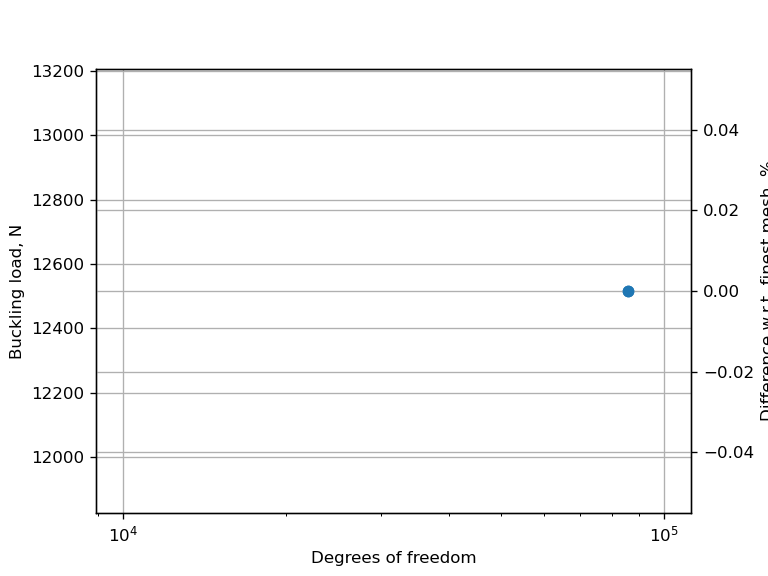

In [18]:
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
fig, ax1 = plt.subplots()  # create a figure and set of axes
buckling_load_line = ax1.semilogx(dofs, linear_buckling_loads, 'o-')

# Create a twin set of axes to plot percentage difference vs degrees of freedom
ax2 = ax1.twinx()
percentage_diff = (linear_buckling_loads/linear_buckling_loads[-1]-1)*100
percentage_diff_line = ax2.plot(dofs, percentage_diff, 'o-')

# Set plot appearance
ax1.set_xlabel('Degrees of freedom')
ax1.set_ylabel('Buckling load, N') #, color=buckling_load_line[0].get_color())
ax2.set_ylabel('Difference w.r.t. finest mesh, %') #, color=percentage_diff_line[0].get_color())
ax1.grid(True)
ax2.grid(True)
plt.show()


We define the mesh to be converged when the difference with respect to the finest mesh is below 1%.

In [19]:
converged_mesh_index = np.where(np.abs(percentage_diff) < 1)[0][0]  # find index corresponding to first percentage difference below 1
element_length_converged_mesh = shell_element_lengths[converged_mesh_index]  # store shell length of converged mesh
no_elements_converged_mesh = no_elements[converged_mesh_index]  # store number of elements of converged mesh
sol_105_buckling_load = np.round(linear_buckling_loads[converged_mesh_index])  # store buckling load of converged mesh approximating to the nearest integer
print(f"""
The mesh is converged for a target shell element length of {element_length_converged_mesh:.1f} mm,
corresponidng to {no_elements_converged_mesh} elements, {dofs[converged_mesh_index]} degrees of freedom
and to a linear buckling load of {sol_105_buckling_load:.0f} N.""")


The mesh is converged for a target shell element length of 169.6 mm,
corresponidng to 14976 elements, 85866 degrees of freedom
and to a linear buckling load of 12517 N.


## Nonlinear analysis: mesh convergence verification <a name="mesh-verification"></a>

***

For our mesh convergence study we have used linear buckling analyses to monitor the change of the buckling load. However, a slender structure like our new box beam might have a highly nonlinear response and consequently the mesh selected from our convergence study might actually be inadequate to capture it. For this reason we want to verify the convergence of the mesh in the nonlinear regime.

We are going to do this by comparing the tip and the local displacement resulting from a nonlinear analysis with two different meshes: the mesh selected from our convergence study and a refined mesh obtained using a half the target element size employed for the selected mesh. To evaluate the local displacement of the two different models we are going to select the node where SOL 105 predits the largest displacement in the critical buckling mode and we'll consider the main displacement component. Looking at the critical buckling modes of the mesh convergence study, we can say that this node corresponds to the one at the center of the first rib-stiffener bay and the main displacement component is along the $z$-axis.

We create our first bdf input using the target element length of the converged mesh. Then we set up SOL 106 with the arc-length method using a combination of parameters for a quasi-constant very fine step size, inspired by the shallow cylindrical shell snap-through example from the _MSC Nastran Demontration Problems Guide - Implicit Nonlinear_.

In [20]:
# Create mesh with converged target element length
box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h,
                                                                    ribs_y_coordinates=ribs_y_locations,
                                                                    stiffeners_x_coordinates=stiffeners_x_locations,
                                                                    stiffeners_height=stiffeners_height,
                                                                    element_length=element_length_converged_mesh)

# Create BDF obejct and apply concentrated load at the tip
box_beam_bdf = box_beam_utils.create_base_bdf_input(E, nu, rho, t, box_beam_mesh.points,
                                                    box_beam_mesh.faces.reshape(-1, 5)[:, 1:])
tip_master_node_id = apply_tip_concentrated_load(box_beam_bdf, force_set_id)

# Setup SOL 106 with arc-length method using parameters for fine resolution of equilibrium path
fine_nlparm_id = 1  # id of NLPARM card with fine arc-length method parameters
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, ninc=100, conv='PUV', eps_p=1e-3, eps_u=1e-3,
                                         max_bisect=10, minalr=.01, maxalr=1.0001, desiter=5, maxinc=1000)

subcase=0 already exists...skipping


To get a nonlinear response from the structure, we apply twice the buckling load predicted by SOL 105.

In [21]:
load_set_id = force_set_id + 1  # id of load set
scale_factor = sol_105_buckling_load*2  # scale factor to apply to the load set
box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])  # add LOAD card
loading_subcase_id = 1  # id of first subcase
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=1, load_set_id=load_set_id)  # create subcase with static load

We run our nonlinear analysis monitoring the 20 smallest-magnitude eigenvalues of the tangent stiffness matrix, so that we can check the stability of the structure.

In [22]:
method_set_id = load_set_id + 1
no_eigenvalues = 20
UPPER_EIGENVALUE = 100.  # upper bound for eigenvalues [N/mm] - set to 10^5 N/m to avoid convergence issues of Lanczos solver
input_name_original_mesh = f"nonlinear_analysis_{no_elements_converged_mesh}_elements"
sol_106_op2_original_mesh = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name_original_mesh, upper_eig=UPPER_EIGENVALUE,
    run_flag=False)


Nastran job nonlinear_analysis_14976_elements.bdf completed
Wall time: 1840.0 s


We read the tip displacement from the op2 file, corresponding to the $z$-displacement of the master node of the tip section.

In [23]:
z_component_index = 2  # index of z component of displacement
original_tip_displacement = sol_106_op2_original_mesh.displacements[loading_subcase_id].data[
    -1, tip_master_node_id - 1, z_component_index]  # read z displacement of subcase 1, last converged iteration

To find the node associated to the local displacement, we need to find the node where SOL 105 predicts the largest displacement for the critical buckling mode. Consequently, we read the op2 file corresponding to the linear buckling analysis performed during the mesh convergence study and we look for the node where the first eigenvector has the largest displacement.

In [24]:
from pyNastran.op2.op2 import read_op2  # import function to read op2 file

# Read op2 file of linear buckling analysis
input_name = f"linear_buckling_{no_elements_converged_mesh}_elements"
sol_105_op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
sol_105_op2 = read_op2(op2_filename=sol_105_op2_filepath, load_geometry=True, debug=None)

# Find node where max displacement occurs
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].data[
    0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].node_gridtype[
    max_displacement_index, 0]

Now we visualize the buckling mode and the location of the selected node.

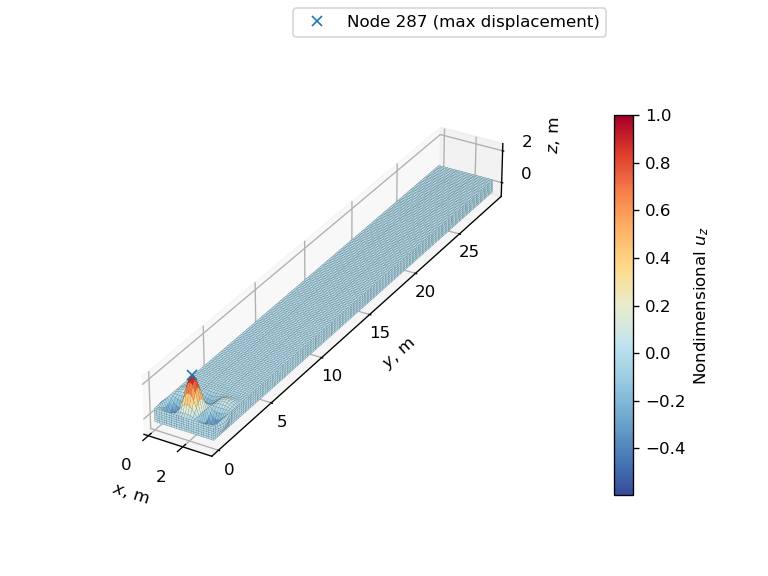

In [25]:
# Plot buckling mode
amplification_factor = 2  # amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Plot node
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz*1e-3 + sol_105_op2.eigenvectors[
    eigenvalue_calculation_subcase_id].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], "x",
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

Successively, we read the local displacement from the op2 file, which corresponds to the $z$-displacement of the selected node.

In [26]:
original_local_displacement = sol_106_op2_original_mesh.displacements[loading_subcase_id].data[
    -1, max_displacement_index, z_component_index]  # read z displacement of subcase 1, last converged iteration

Now we create the model with a refined mesh, where we prescribe half of the element length used for the original model.

In [27]:
# Create mesh with half of the converged target element length
box_beam_refined_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(
    width=w, height=h, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
    stiffeners_height=stiffeners_height, element_length=element_length_converged_mesh/2)

# Create BDF object and apply concentrated load at the tip
refined_mesh_box_beam_bdf = box_beam_utils.create_base_bdf_input(E, nu, rho, t, box_beam_refined_mesh.points,
                                                                 box_beam_refined_mesh.faces.reshape(-1, 5)[:, 1:])
refined_mesh_tip_master_node_id = apply_tip_concentrated_load(refined_mesh_box_beam_bdf, force_set_id)

subcase=0 already exists...skipping


We first run a linear buckling analysis with SOL 105, in order to find the node where the critical buckling mode has the largest displacement. Then we plot together the critical buckling mode and the mentioned node.

Nastran job linear_buckling_48300_elements.bdf completed
Wall time: 31.0 s


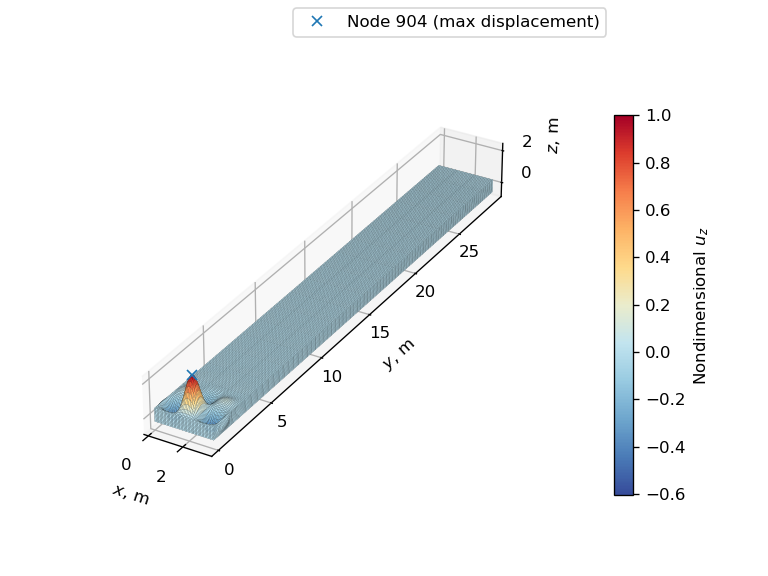

In [28]:
# Run SOL 105 and return OP2 object
no_elements_refined_mesh = len(refined_mesh_box_beam_bdf.elements)
input_name = f"linear_buckling_{no_elements_refined_mesh}_elements"
sol_105_op2_refined_mesh = pynastran_utils.run_sol_105_buckling_analysis(
    bdf_object=refined_mesh_box_beam_bdf.__deepcopy__({}), static_load_set_id=force_set_id,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)

# Find node where max displacement occurs
refined_mesh_max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2_refined_mesh.eigenvectors[
    eigenvalue_calculation_subcase_id].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
refined_mesh_max_displacement_node_id = sol_105_op2_refined_mesh.eigenvectors[
    eigenvalue_calculation_subcase_id].node_gridtype[refined_mesh_max_displacement_index, 0]

# Plot buckling mode
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2_refined_mesh,
                                                 subcase_id=eigenvalue_calculation_subcase_id,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Plot node
refined_mesh_max_displacement_node_xyz = sol_105_op2_refined_mesh.nodes[
    refined_mesh_max_displacement_node_id].xyz*1e-3 + sol_105_op2_refined_mesh.eigenvectors[
        eigenvalue_calculation_subcase_id].data[0, refined_mesh_max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(refined_mesh_max_displacement_node_xyz[0], refined_mesh_max_displacement_node_xyz[1],
        refined_mesh_max_displacement_node_xyz[2], "x",
        label=f"Node {refined_mesh_max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

We define the subcase for the nonlinear analysis applying the same load as for the original model, set up SOL 106 with the arc-length method using the same parameters of the last analysis, and we run the analysis.

In [29]:
# Create static load subcase with twice the buckling load predicted by SOL 105
refined_mesh_box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
pynastran_utils.create_static_load_subcase(bdf_object=refined_mesh_box_beam_bdf, subcase_id=loading_subcase_id,
                                           load_set_id=load_set_id)

# Setup SOL 106 with arc-length method using parameters for fine resolution of equilibrium path
pynastran_utils.set_up_arc_length_method(bdf_object=refined_mesh_box_beam_bdf, ninc=100, conv='PUV', eps_p=1e-3,
                                         eps_u=1e-3, max_bisect=10, minalr=.01, maxalr=1.0001, desiter=5, maxinc=1000)

# Run analysis
input_name_refined_mesh = f"nonlinear_analysis_{no_elements_refined_mesh}_elements"
sol_106_op2_refined_mesh = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=refined_mesh_box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name_refined_mesh, upper_eig=UPPER_EIGENVALUE, run_flag=False)

Nastran job nonlinear_analysis_48300_elements.bdf completed
Wall time: 10534.0 s


Also in this case we read the local and tip displacement from the op2 file.

In [30]:
refined_mesh_local_displacement = sol_106_op2_refined_mesh.displacements[loading_subcase_id].data[
    -1, refined_mesh_max_displacement_index, z_component_index]  # read z displacement of local node in subcase 1, last converged iteration
refined_mesh_tip_displacement = sol_106_op2_refined_mesh.displacements[loading_subcase_id].data[
    -1, refined_mesh_tip_master_node_id - 1, z_component_index]  # read z displacement of tip node in subcase 1, last converged iteration

Finally, we can calculate the percentage difference of the displacements obtained with the refined mesh w.r.t. the displacements obtained with the original mesh.

In [31]:
print(f"""
Percentage difference of tip displacement: {(refined_mesh_tip_displacement/original_tip_displacement - 1)*100:.1f} %""")
print(f"""
Percentage difference of local displacement: {(refined_mesh_local_displacement/original_local_displacement - 1)*100:.1f} %""")


Percentage difference of tip displacement: 1.0 %

Percentage difference of local displacement: -3.4 %


The difference for both displacements is smaller than 5%, suggesting that the mesh selected with the convergence study appears to be adequate for the kind of nonlinear analyses that we are going to carry out in the remainder of the notebook. However, the final value of local and tip displacements gives only a partial picture of the accuracy of the mesh. In fact, in our nonlinear analyses the equilibrium path followed by the structure might be more important than the final deformation. For this reason, we are now going to compare the equilibrium paths followed by the two models for the analyses that we've just performed.

To do this, we plot the equilibrium paths in a 3D equilibrium diagram, where we use the $x$-axis to represent the local displacement, the $y$-axis to represent the tip displacement and the $z$-axis to represent the applied load. We read the history of these quantities from the op2 files using the function `read_load_displacement_history` from the `pynastran_utils` module. The local displacement is nondimensionalized with the width of the box beam, the tip displacement with the length of the box beam and the applied load with the buckling load predicted by SOL 105.

In [32]:
# Read tip and local displacements of the original mesh
local_displacements = {}
tip_displacements = {}
applied_loads = {}
_, _, local_displacements["original mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_original_mesh, displacement_node_id=max_displacement_node_id)
_, applied_loads["original mesh"], tip_displacements["original mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_original_mesh, displacement_node_id=tip_master_node_id)

# Read tip and local displacements of the refined mesh
_, _, local_displacements["refined mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_refined_mesh, displacement_node_id=refined_mesh_max_displacement_node_id)
_, applied_loads["refined mesh"], tip_displacements["refined mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_refined_mesh, displacement_node_id=refined_mesh_tip_master_node_id)
    
# Create dictionaries with nondimensional tip displacements and applied loads
nondimensional_local_displacements = {key: local_displacements[key][loading_subcase_id][:, z_component_index]/w
                                      for key in local_displacements}
nondimensional_tip_displacements = {key: tip_displacements[key][loading_subcase_id][:, z_component_index]/l
                                    for key in tip_displacements}
nondimensional_applied_loads = {key: applied_loads[key][loading_subcase_id][:, z_component_index]/sol_105_buckling_load
                                for key in applied_loads}

Finally, we plot together the equilibrium paths of the two models.

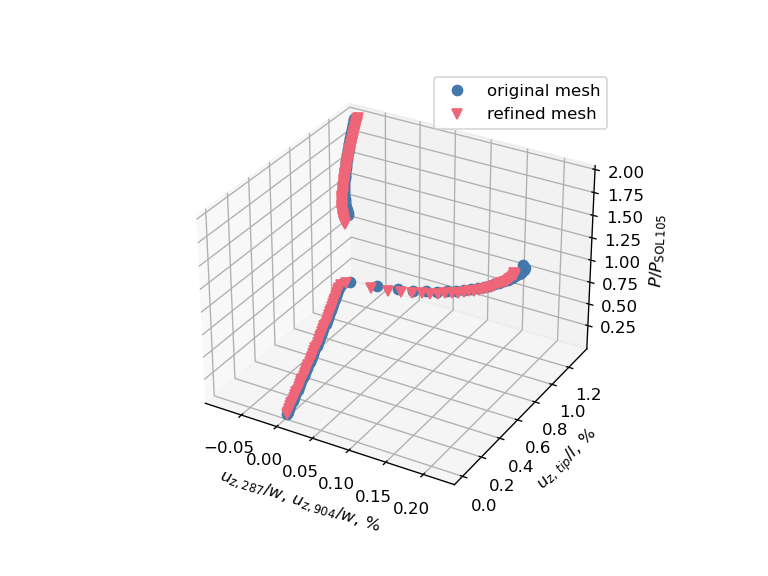

In [33]:
import tol_colors as tc  # package for colorblind-friendly colors
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # list with default color cycle
markers = list(Line2D.markers.keys())[2:]  # list of marker characters

# Create 3D plot of equilibrium diagram
plt.figure()
ax_3d = plt.axes(projection="3d")
for count, key in enumerate(nondimensional_local_displacements):
    ax_3d.plot3D(nondimensional_local_displacements[key]*100, nondimensional_tip_displacements[key]*100,
                 nondimensional_applied_loads[key], markers[count], color=colors[count], label=key)

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{z, {max_displacement_node_id:d}}}/w,\,u_{{z, {refined_mesh_max_displacement_node_id:d}}}/w$, %")
ax_3d.set_ylabel("$u_{z,\,tip}/l$, %")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
ax_3d.legend()
plt.show()

The two equilibrium paths are very close to each other, suggesting that the original mesh is adequate for our nonlinear analyses. However, they appear to be discontinuous, indicating that the arc-length solver has probably jumped from the natural equilibrium path to another path. This is a sign that the nonlinear analysis parameters used for the analyses are not adequate to follow the natural equilibrium path of the structure for this loading case, and we need to investigate this further.

Looking at the f06 file of both analyses we notice that the vast majority of load steps converged in 2 or 3 iterations. The number of iterations is greater only for the load increments close to $P/P_\text{SOL 105}=1$ and corresponding to the jump. In particular, in both analyses the number of iteartions reach the maximum value at the load step corresponding to the jump, namely 15 iterations for the analysis with the original mesh, and 14 iterations for the refined mesh. What is happening here?

The arc-length method is a predictor-corrector method, meaning that it first makes a prediction of the next equilibrium point by taking a tangent step to the load-displacement diagram and then it corrects the prediction to find the actual equilibrium point by means of Newton-Raphson iterations. The prediction is thus based on the tangent stiffness matrix evaluated at the last converged equilibrium point. If the equilibrium path is highly nonlinear around such point, the predictor step may land relatively far from the followed path. In the event that the predictor step lands closer to a different path, the corrector step will make the solver converge to this new path instead of the old path. When this happens it is likely that the corrector step requires many iterations to converge, as it tries to converge to an equilibrium point that is nevertheless relatively far from the last converged point. This is what may be happening in our case.

For this reason, we repeat both analyses limiting the maximum number of iterations for each step to 3. This means that the solver will reduce the size of the predictor step where the corrector step cannot converge "easily", that is to say in presence of strong nonlinearities. In this way, we expect the solver to follow the natural equilibrium path of the structure without jumping.

In [34]:
# Run analysis for input bdf with original mesh
box_beam_bdf.nlparms[fine_nlparm_id].max_iter = 3  # reduce maximum number of iterations to 3
box_beam_bdf.nlparms[fine_nlparm_id].ninc = 102  # reduce initial load increment
box_beam_bdf.nlpcis[fine_nlparm_id].mxinc = 1200  # increase maximum number of increments to 1200
input_name_original_mesh = f"nonlinear_analysis_{no_elements_converged_mesh}_elements_maxiter3"
sol_106_op2_original_mesh = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name_original_mesh, upper_eig=UPPER_EIGENVALUE, run_flag=False)

# Run analysis for input bdf with refined mesh
refined_mesh_box_beam_bdf.nlparms[fine_nlparm_id].max_iter = 3  # reduce maximum number of iterations to 3
refined_mesh_box_beam_bdf.nlparms[fine_nlparm_id].ninc = 102  # reduce initial load increment
refined_mesh_box_beam_bdf.nlpcis[fine_nlparm_id].mxinc = 1300  # increase maximum number of increments to 2500
input_name_refined_mesh = f"nonlinear_analysis_{no_elements_refined_mesh}_elements_maxiter3"
sol_106_op2_refined_mesh = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=refined_mesh_box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name_refined_mesh, upper_eig=UPPER_EIGENVALUE, run_flag=False)

Nastran job nonlinear_analysis_14976_elements_maxiter3.bdf completed
Wall time: 14645.0 s


Nastran job nonlinear_analysis_48300_elements_maxiter3.bdf completed
Wall time: 73569.0 s


We read the resulting history of the load and displacements and plot the equilibrium paths.

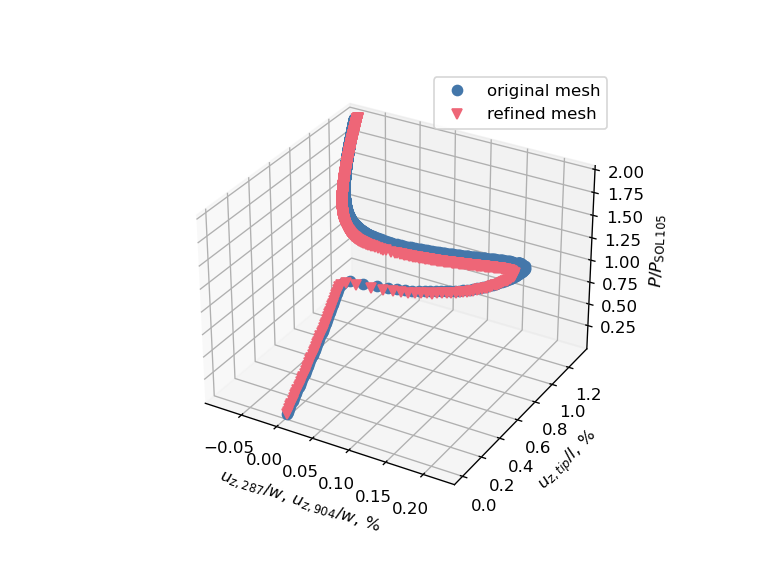

In [35]:
# Read tip and local displacements of the original mesh
local_displacements = {}
tip_displacements = {}
applied_loads = {}
_, _, local_displacements["original mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_original_mesh, displacement_node_id=max_displacement_node_id)
_, applied_loads["original mesh"], tip_displacements["original mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_original_mesh, displacement_node_id=tip_master_node_id)

# Read tip and local displacements of the refined mesh
_, _, local_displacements["refined mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_refined_mesh, displacement_node_id=refined_mesh_max_displacement_node_id)
_, applied_loads["refined mesh"], tip_displacements["refined mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_refined_mesh, displacement_node_id=refined_mesh_tip_master_node_id)
    
# Create dictionaries with nondimensional tip displacements and applied loads
nondimensional_local_displacements = {key: local_displacements[key][loading_subcase_id][:, z_component_index]/w
                                      for key in local_displacements}
nondimensional_tip_displacements = {key: tip_displacements[key][loading_subcase_id][:, z_component_index]/l
                                    for key in tip_displacements}
nondimensional_applied_loads = {key: applied_loads[key][loading_subcase_id][:, z_component_index]/sol_105_buckling_load
                                for key in applied_loads}

# Create 3D plot of equilibrium diagram
plt.figure()
ax_3d = plt.axes(projection="3d")
for count, key in enumerate(nondimensional_local_displacements):
    ax_3d.plot3D(nondimensional_local_displacements[key]*100, nondimensional_tip_displacements[key]*100,
                 nondimensional_applied_loads[key], markers[count], color=colors[count], label=key)

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{z, {max_displacement_node_id:d}}}/w,\,u_{{z, {refined_mesh_max_displacement_node_id:d}}}/w$, %")
ax_3d.set_ylabel("$u_{z, tip}/l$, %")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
ax_3d.legend()
plt.show()

These results show that we have successfully managed to avoid the jump and that the two curves indicate the same overall response of the structure. In addition, we can see that, for both meshes, the equilibrium path found after the jump in the previous analysis is actually connected to the natural equilibrium path!

Let's calculate again the percentage difference of the local and tip displacements at the end of the analyses.

In [36]:
print(f"""
Percentage difference of local displacement: {(nondimensional_local_displacements["refined mesh"][-1]/
                                               nondimensional_local_displacements["original mesh"][-1] - 1)*100:.1f} %""")
print(f"""
Percentage difference of tip displacement: {(nondimensional_tip_displacements["refined mesh"][-1]/
                                             nondimensional_tip_displacements["original mesh"][-1] - 1)*100:.1f} %""")


Percentage difference of local displacement: -3.4 %

Percentage difference of tip displacement: 1.0 %


Basically no difference, amazing!

In the load-displacement diagram we also observe that, along the newly found part of the natural equilibrium path, the applied load decreases and then increases again. This suggests the presence of two limit points along the equilibrium path, associated with an unstable equilibrium between the two. We can check this by plotting the eigenvalues of the tangent stiffness matrix.

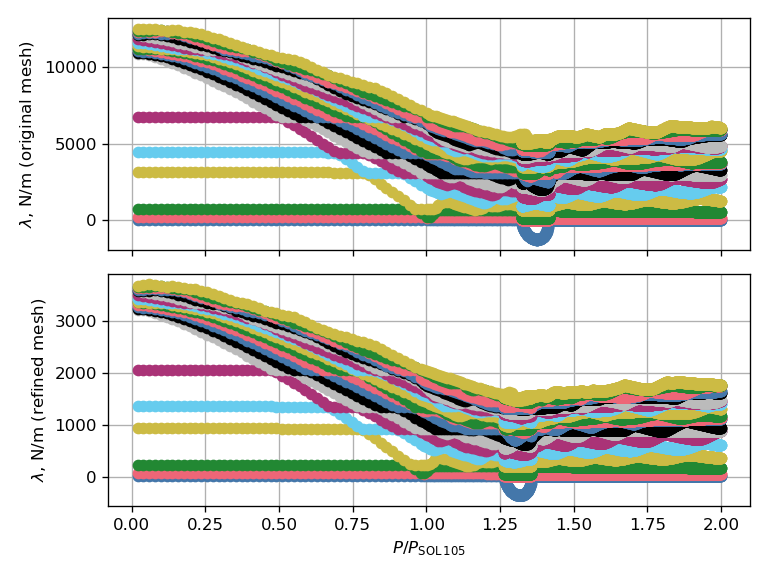

In [37]:
# Read eigenvalues obtained with refence mesh
f06_path = os.path.join(analysis_directory_path, input_name_original_mesh + '.f06')  # path to .f06 file
eigenvalues_original_mesh = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Read eigenvalues obtained with refined mesh
f06_path = os.path.join(analysis_directory_path, input_name_refined_mesh + '.f06')  # path to .f06 file
eigenvalues_refined_mesh = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot for refence mesh
ax1.plot(nondimensional_applied_loads["original mesh"], eigenvalues_original_mesh.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax1.set_ylabel("$\lambda$, N/m (original mesh)")
ax1.grid(True)

# Plot for the refined mesh
ax2.plot(nondimensional_applied_loads["refined mesh"], eigenvalues_refined_mesh.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax2.set_xlabel("$P/P_\mathrm{SOL\/105}$")
ax2.set_ylabel("$\lambda$, N/m (refined mesh)")
ax2.grid(True)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

The eigenvalue diagrams show indeed the presence of a negative eigenvalue, however within a different load range for the two meshes. Let's find for both meshes the load corresponding to the first limit point, or in other words to the loss of stability, and calculate the percentage difference of the refined mesh with respect to the original mesh.

In [38]:
# Find applied load at limit point for original mesh
first_negative_eigenvalue_index_original_mesh = np.where(eigenvalues_original_mesh[0, :] < 0)[0][0]  # find index of first negative eigenvalue
nondimensional_applied_load_limit_point_original_mesh = np.mean(nondimensional_applied_loads["original mesh"][
    first_negative_eigenvalue_index_original_mesh - 1:first_negative_eigenvalue_index_original_mesh + 1])  # calculate applied load at limit point as the mean of the applied loads between positive and negative eigenvalue

# Find applied load at limit point for refined mesh
first_negative_eigenvalue_index_refined_mesh = np.where(eigenvalues_refined_mesh[0, :] < 0)[0][0]  # find index of first negative eigenvalue
nondimensional_applied_load_limit_point_refined_mesh = np.mean(nondimensional_applied_loads["refined mesh"][
    first_negative_eigenvalue_index_refined_mesh - 1:first_negative_eigenvalue_index_refined_mesh + 1])  # calculate applied load at limit point as the mean of the applied loads between positive and negative eigenvalue

# Print applied loads and percentage difference
print(f"""
Nondimensional applied load at first limit point:
- original mesh: {nondimensional_applied_load_limit_point_original_mesh:.2f}
- refined mesh: {nondimensional_applied_load_limit_point_refined_mesh:.2f}
Percentage difference: {(nondimensional_applied_load_limit_point_refined_mesh/nondimensional_applied_load_limit_point_original_mesh - 1)*100:.1f} %""")


Nondimensional applied load at first limit point:
- original mesh: 1.42
- refined mesh: 1.36
Percentage difference: -4.2 %


Also for the first limit point the difference is smaller than 5%, suggesting that the original mesh is adequate for our nonlinear analyses.

Finally, it's interesting to visualize the deformation of the box beam along the equilibrium path, especially to observe what part of the box beam is involved in the snap-through associated with the limit point bifucations. We select three points along the load-displacement curve, one at $P/P_\mathrm{SOL 105}=0.5$, to visualize the deformation in the linear paer of the response, and the other two just before and after the snap. We only plot the deformation of the original model and we amplify the displacements by a factor 50 for visualization purposes.

Deformation at P/P_SOL 105 = 0.5:


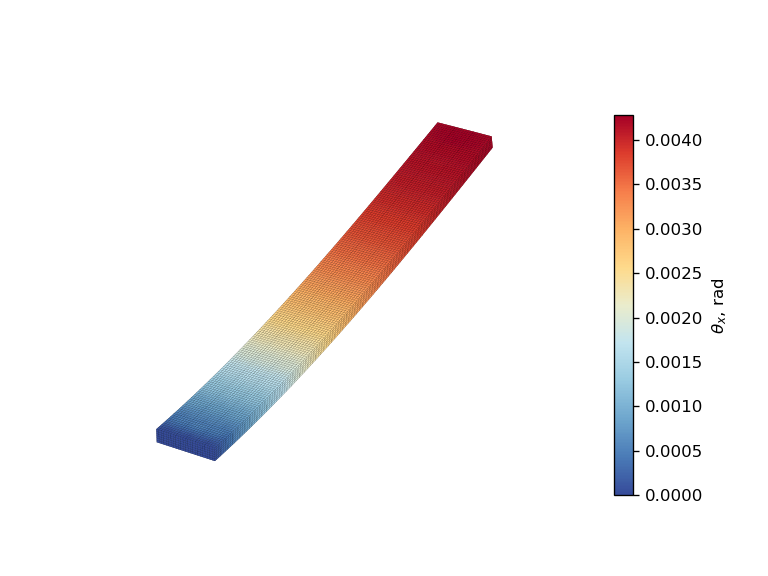

Deformation at P/P_SOL 105 = 1.42:


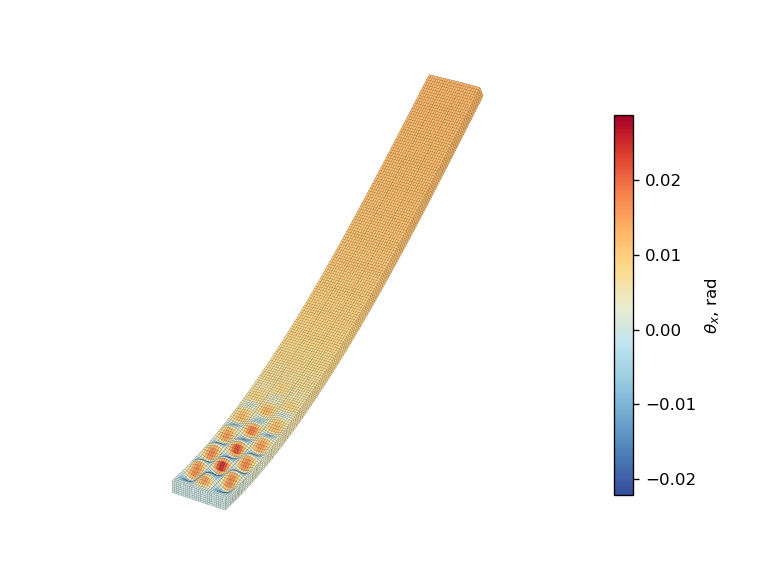

Deformation at P/P_SOL 105 = 1.42:


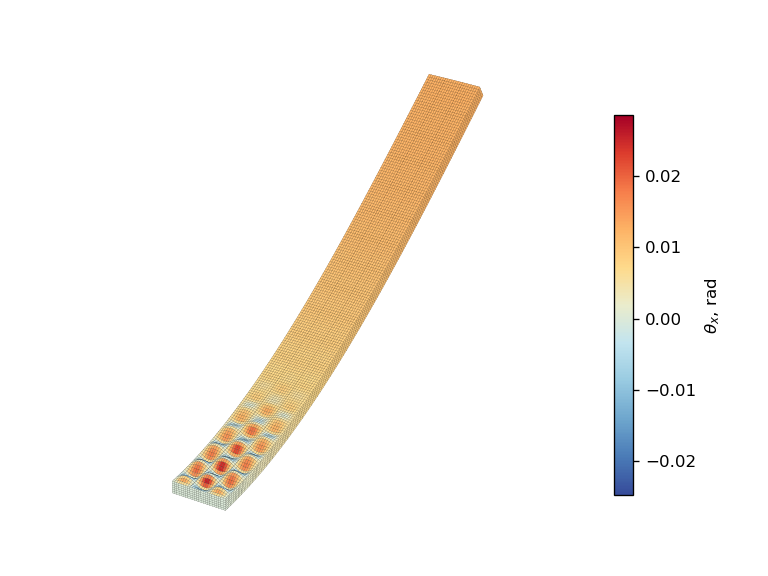

In [39]:
# Plot deformation at P/P_SOL 105 = 0.5
nondimensional_applied_linear_regime = .5
increment_number = np.argmin(np.abs(nondimensional_applied_loads["original mesh"] - nondimensional_applied_linear_regime)) + 1  # find number of closest converged increment to applied load
amplification_factor = 50  # amplification factor for displacements
print("Deformation at P/P_SOL 105 = 0.5:")
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_original_mesh, subcase_id=loading_subcase_id, load_step=increment_number,
                                                      displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.axis('off')
plt.show()

# Plot deformation just before snap
nondimensional_applied_load_before_snap = nondimensional_applied_loads["original mesh"][first_negative_eigenvalue_index_original_mesh - 1]  # find applied load just before snap (last stable point)
print(f"Deformation at P/P_SOL 105 = {nondimensional_applied_load_before_snap:.2f}:")
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_original_mesh, subcase_id=loading_subcase_id,
                                                      load_step=first_negative_eigenvalue_index_original_mesh,
                                                      displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.axis('off')
plt.show()

# Plot deformation just after snap
subsequent_values = nondimensional_applied_loads["original mesh"][first_negative_eigenvalue_index_original_mesh + 10:]  # consider only applied loads after snap
closest_index_in_subsequent = np.argmax(subsequent_values >= nondimensional_applied_load_before_snap)  # find index of closest value to applied load at first limit point
closest_index = first_negative_eigenvalue_index_original_mesh + 10 + closest_index_in_subsequent  # sum found index to index of first negative eigenvalue
nondimensional_applied_load_after_snap = nondimensional_applied_loads["original mesh"][closest_index]
print(f"Deformation at P/P_SOL 105 = {nondimensional_applied_load_after_snap:.2f}:")
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_original_mesh, subcase_id=loading_subcase_id, load_step=closest_index + 1,
                                                      displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.axis('off')
plt.show()

The deformation at $P/P_\text{SOL 105}=0.5$ is analogous to the one of a beam under linear deformation. The deformation just before the first limit point is characterized by one half-wave for the rib-stiffener bays between the first two ribs, and by two half-waves for the rib-stiffener bays between the successive ribs. After the snap, the deformation of the rib-stiffener bays between first two ribs changes into two half-waves and the rib-stiffener bays betwen successive ribs maintain the same number of half-waves.

## Nonlinear analysis: sensitivity of nonlinear analysis parameters <a name="nonlinear-analysis-parameters"></a>

***

Now we want to assess the influence of SOL 106's nonlinear analysis parameters on the results of the analysis, and possibly find some of the complementary paths while doing so. Similarly to our previous box beam versions, we apply twice the buckling load predicted by SOL 105, vary several parameters of the NLPARM and the NLPCI cards and look at how the load-displacement diagram changes.

We use the same `BDF` object used for the verification of the convergence of the mesh in the nonlinear regime, and we define new NLPARM and NLPCI cards with default parameters, assigning those to the first subcsase. The new cards with the default parameters correspond to a coarse arc-length step size, and we are going to apply the load in the first subcase with this approach to potentially allow the solver to jump to one or more complementary paths, so that we can verify their existence.

In [40]:
coarse_nlparm_id = 2
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, nlparm_id=coarse_nlparm_id, subcase_id=loading_subcase_id)

To monitor how the nonlinear analysis parameters affect the results, we want to observe how the followed equilibrium paths change. In our previous notebooks we have always plotted the load-displacement diagram in terms of applied loads against tip displacements. However, given the complexity of the natural equilibrium path of the present box beam, plotting only those two quantities is probably not going to be very descriptive. For this reason, this time we want to monitor the changes in the 3D equilibrium diagram, where we combine local displacement, tip displacement and applied load.

We define the function `plot_load_displacement_curve`, which runs the Nastran analysis, reads the displacement and load history from the op2 file and plots the corresponding load-displacement curve on a pre-defined figure, nondimensionalizing the local displacement with the width of the box beam, tip displacement with the length, and the applied load with the buckling load predicted by SOL 105.

In [41]:
def plot_load_displacement_curve(bdf_input, filename, axes, subcase_id, marker_style, line_label, run_flag=False):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=filename, run_flag=run_flag)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(analysis_directory_path, filename + '.op2')
    op2 = read_op2(op2_path, debug=None)
    _, p, tip_disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=tip_master_node_id)
    _, _, local_disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=max_displacement_node_id)
    # Plot load-displacement curve on input axes
    axes.plot3D(local_disp[subcase_id][:, z_component_index]/w*100, tip_disp[subcase_id][:, z_component_index]/l*100,  # plot displacement in % of beam width and length
                p[subcase_id][:, z_component_index]/sol_105_buckling_load, marker_style, label=line_label)

### Error function <a name="error-function"></a>

We start our sensitivity study by looking at the error function. We consider four different combinations of error functions:
- load and energy (default);
- load and energy with vector component checking;
- load and displacement;
- load and displacement with vector component checking;
- load, energy and displacement;
- load, energy and displacement with vector component checking. 

In [42]:
error_functions = ['PW', 'PWV', 'PU', 'PUV', 'PWU', 'PWUV']

Since we want to compare the results with the natural equilibrium path, we define a function that creates a new figure and plots the natural equilibrium path on the 3D equilibrium diagram. We'll call this function before running our analyses and plotting the resulting load-displacement curves.

In [43]:
def plot_natural_equilibriunm_path():
    # Create 3D plot of equilibrium diagram
    plt.figure()
    axes = plt.axes(projection='3d')
    axes.plot3D(nondimensional_local_displacements["original mesh"]*100, nondimensional_tip_displacements["original mesh"]*100,
                nondimensional_applied_loads["original mesh"], 'o', label="natural path")
    # Set plot appearance
    axes.set_xlabel(f"$u_{{z, {max_displacement_node_id:d}}}/w$, %")
    axes.set_ylabel("$u_{z, tip}/l$, %")
    axes.set_zlabel("$P/P_\mathrm{SOL\/105}$")
    axes.grid(visible=True)
    # Return axes object
    return axes

Let's plot the natural equilibrium path, run the analyses with the different error functions and plot the results.

Nastran job nonlinear_analysis_error_function_PW.bdf completed
Wall time: 234.0 s


Nastran job nonlinear_analysis_error_function_PWV.bdf completed
Wall time: 219.0 s


Nastran job nonlinear_analysis_error_function_PU.bdf completed
Wall time: 100.0 s


Nastran job nonlinear_analysis_error_function_PUV.bdf completed
Wall time: 97.0 s


Nastran job nonlinear_analysis_error_function_PWU.bdf completed
Wall time: 104.0 s


Nastran job nonlinear_analysis_error_function_PWUV.bdf completed
Wall time: 95.0 s


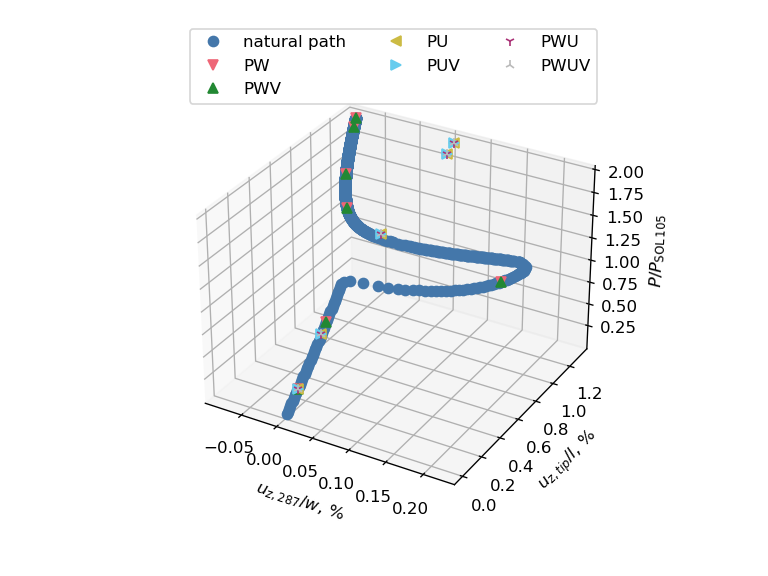

In [44]:
# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Run analysis for each set of error functions and plot load-displacement curve
for count, fun in enumerate(error_functions):
    box_beam_bdf.nlparms[coarse_nlparm_id].conv = fun
    input_filename = "nonlinear_analysis_error_function_" + fun
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1], f"{fun}", run_flag=False)

# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.11), loc='upper center', ncol=3)
plt.show()

In the load-displacement diagram, the displacement error function emerges as the only factor making a difference. The analyses employing this error function converge to the same sequence of equilibrium points, and analyses that exclude the displacement error function converge to a different, yet consistent, sequence of equilibrium points. Nevertheless, the final equilibrium point appear to be the same for all analyses, suggesting that the displacement error function does not affect the final equilibrium point.

Furthermore, for all analyses we can see that only the first two equilibrium points lie on the natural equilibrium path, while the following points appear not to belong to it. This suggests that the solver has jumped to a complementary path, and we want to investigate its shape.

To do this, we are going to unload the structure from the last equilibrium point using a fine arc-length step size. We restore the default error function, define a second subcase with zero applied load, assign the NLPARM and NLPCI cards with fine arc-length step size settings and run the analysis.

In [45]:
# Modify nonlinear analysis parameters
box_beam_bdf.nlparms[coarse_nlparm_id].conv = error_functions[2]  # set error function to PU

# Define second subcase to unload the structure
zero_load_set_id = load_set_id + 1  # id of LOAD card
box_beam_bdf.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_set_id])  # add LOAD card with zero applied load
unloading_subcase_id = 2  # id of second subcase
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=unloading_subcase_id, load_set_id=zero_load_set_id)  # create subcase with zero applied load
box_beam_bdf.case_control_deck.subcases[unloading_subcase_id].add_integer_type('NLPARM', fine_nlparm_id)  # use NLPARM and NLPCI with fine arc-length step in second subcase

# Run analysis
input_name = "equilibrium_path_verification_" + error_functions[2]
sol_106_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, upper_eig=UPPER_EIGENVALUE, run_flag=False)

Nastran job equilibrium_path_verification_PU.bdf completed
Wall time: 12311.0 s


Let's read the load and displacement history from the `OP2` object and plot together the path followed in the second subcase and the natural equilibrium path.

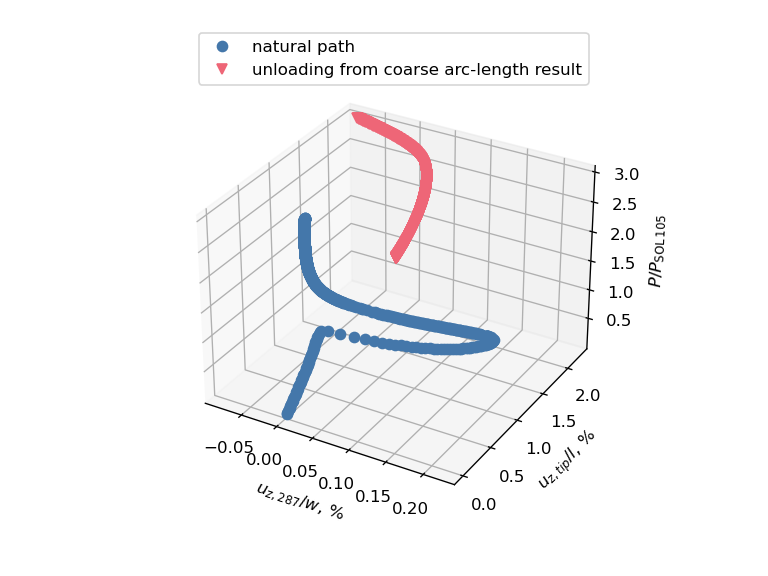

In [46]:
# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Read load and displacement history and plot load-displacement curve of second subcase
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=tip_master_node_id)
_, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=max_displacement_node_id)
ax.plot3D(local_displacements[unloading_subcase_id][:, z_component_index]/w*100, tip_displacements[unloading_subcase_id][:, z_component_index]/l*100,
            applied_loads[unloading_subcase_id][:, z_component_index]/sol_105_buckling_load, markers[1], label="unloading from coarse arc-length result")

# Show plot
ax.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center')
plt.show()

What is happening in the orange curve? The arc-length solver starts from the final equilibrium point of the first subcase and unloads the structure following the equilibrium path down to approximately $P/P_\mathrm{SOL\,105}=1.28$, where it jumps to another path. On this path the solver keeps unloading the structure down to $P/P_\mathrm{SOL\,105}=0.98$, where it finally jumps to the natural path and follows it down to zero load.

Let's have a look at the eigenvalues of the tangent stiffness matrix along this paths.

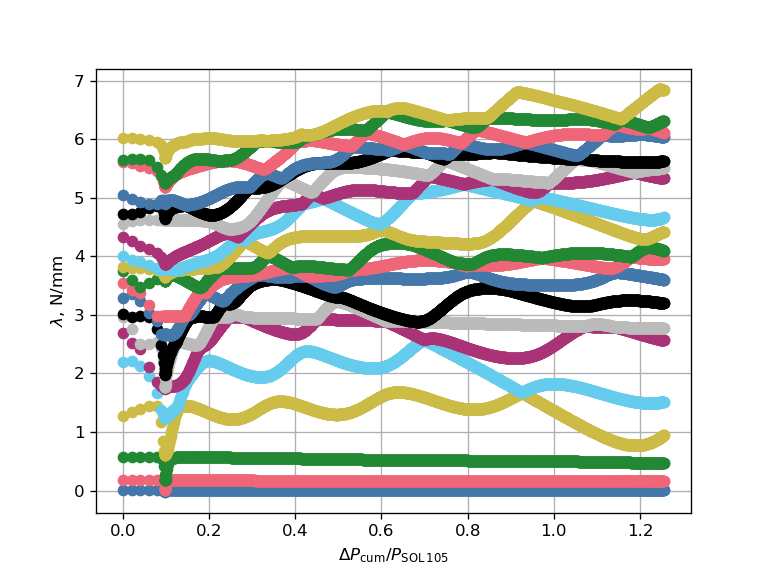

In [47]:
# Read eigenvalues from f06 file
f06_filepath = os.path.join(analysis_directory_path, input_name + ".f06")
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)

# Extract eigenvalues for second subcase
no_increments_first_subcase = len(applied_loads[loading_subcase_id])
eigenvalues = eigenvalues[:, no_increments_first_subcase - 1:]

# Find cumulative load increments
increments_diff = np.abs(np.ediff1d(applied_loads[unloading_subcase_id][:, z_component_index]/sol_105_buckling_load))
cumulative_load_increments = np.insert(np.cumsum(increments_diff), 0, 0)

# Plot eigenvalues vs applied load
plt.figure()
plt.plot(cumulative_load_increments, eigenvalues.T, 'o')

# Set plot appearance
plt.xlabel("$\Delta P_\mathrm{cum}/P_\mathrm{SOL\/105}$")
plt.ylabel("$\lambda$, N/mm")
plt.grid(visible=True)
plt.show()

Deformation at the end of natural path:


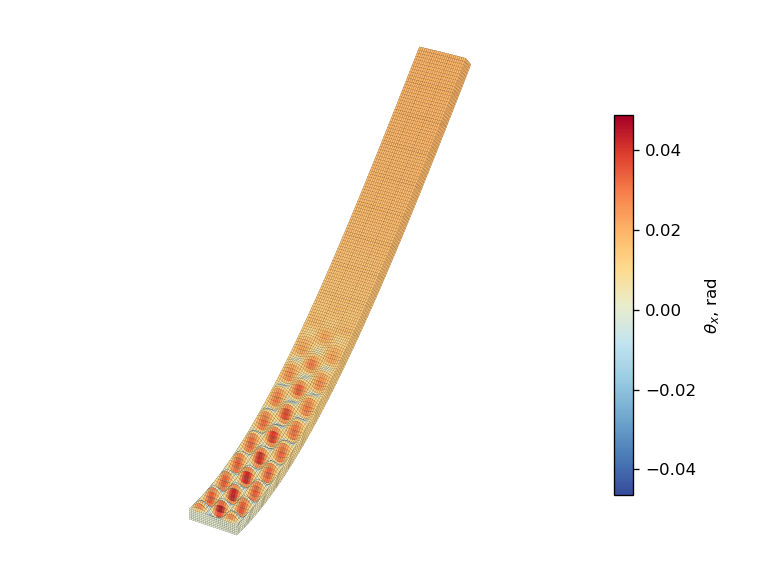

Deformation at the end of unloading:


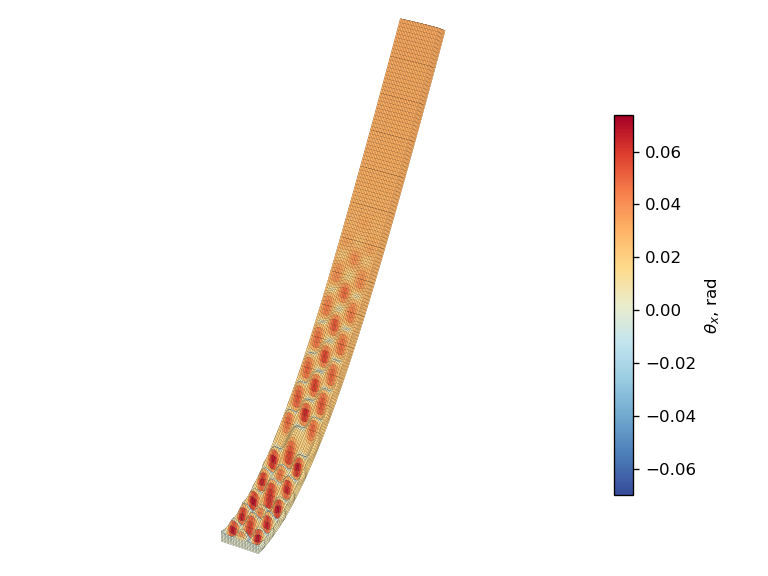

In [48]:
# Plot deformation at the end of natural path
print("Deformation at the end of natural path:")
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_original_mesh, displacement_component='rx',
                                                      colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)
adjust_3d_plot(ax, cbar)
plt.axis('off')
plt.show()

# Plot deformation at the end of unloading
print("Deformation at the end of unloading:")
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2, subcase_id=unloading_subcase_id,
                                                      displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.axis('off')
plt.show()

The eigenvalues show that all the equilibrium points found by the arc-length solver are stable. So, why do we observe the two jumps?

The arc-length method is a predictor-corrector method, meaning that it first predicts the next equilibrium point and then corrects it to obtain the actual equilibrium point. The prediction is based on the tangent stiffness matrix, which is calculated at the previous equilibrium point. If the structure is highly nonlinear around the current point, the predictor step may land relatively far from the current path. In the event that the predictor step lands closer to a different path, the corrector step will make the solver converge to this new path instead of the old path. This is what may be happening in our case, with solver jumping to stable segments of different equilibrium path.

At this point, we turn our attention at the diagnostic messages printed for each iteration in the f06 file to find some clues that may confirm our hypothesis.

We notice that all converged iterations achieve convergence in 2 or 3 iterations, except for the two instances where the solver jumps to a different path. In these cases the solver takes 8 and 4 iterations to converge. This suggests that the solver is having more difficulties in converging to the equilibrium points corresponding to the jumps. A possible explanation for this is that when the predictor step lands closer to a different path, it is unlikely that it lands very close to such path, allowing the corrector step to converge in few iterations. In other words, when the predictor step moves away from the current path, it can get closer to a different path but it will probably land relatively far from both paths, making the corrector step converge in more iterations.

For this reason, we repeat the analysis with the following strategy: we limit the maximum number of iterations for each step to 3 and we increase the maximum number of bisections to 20, so that the solver can halve the step size as many times as needed to converge in maximum 3 iterations.

Let's modify the NLPARM and NLPCI card of the second subcase, run the analysis and plot the results.

Nastran job nonlinear_analysis_error_function_PW_maxiter3.bdf completed
Wall time: 1746.0 s


Nastran job nonlinear_analysis_error_function_PU_maxiter3.bdf completed
Wall time: 2786.0 s


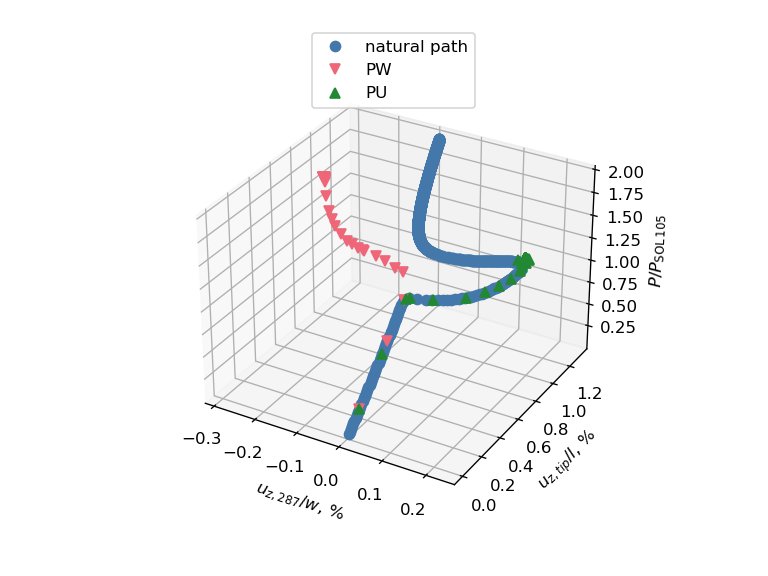

In [49]:
error_functions = ['PW', 'PU']
box_beam_bdf.nlparms[coarse_nlparm_id].max_iter = 3
box_beam_bdf.nlparms[coarse_nlparm_id].max_bisect = 20
box_beam_bdf.nlpcis[coarse_nlparm_id].mxinc = 60
del box_beam_bdf.subcases[unloading_subcase_id]

# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Run analysis for each set of error functions and plot load-displacement curve
for count, fun in enumerate(error_functions):
    box_beam_bdf.nlparms[coarse_nlparm_id].conv = fun
    input_filename = "nonlinear_analysis_error_function_" + fun + "_maxiter3"
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1], f"{fun}", run_flag=False)

# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center')
plt.show()

Comment

### Convergence tolerance <a name="convergence-tolerance"></a>

The second parameter that we consider is the convergence tolerance. Let's take three different combinations of load and energy tolerances, taken from [table 21](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/qrg/bulkno/TOC.NLPARM.xhtml) of MSC Nastran *Quick Reference Guide* manual on the default tolerances for static nonlinear SOL 106 models:
- $EPSP=EPSU=10^{-1}$;
- $EPSP=EPSU=10^{-2}$ (default);
- $EPSP=EPSU=10^{-3}$.

Let's define the list of convergence tolerances, run the analyses and visualize the results.

Nastran job nonlinear_analysis_epsp1e-01_epsw1e-01.bdf completed
Wall time: 1593.0 s


Nastran job nonlinear_analysis_epsp1e-02_epsw1e-03.bdf completed
Wall time: 1885.0 s


Nastran job nonlinear_analysis_epsp1e-03_epsw1e-07.bdf completed
Wall time: 2266.0 s


Nastran job nonlinear_analysis_epsp1e-01_epsu1e-01.bdf completed
Wall time: 164.0 s


Nastran job nonlinear_analysis_epsp1e-02_epsu1e-02.bdf completed
Wall time: 2784.0 s


Nastran job nonlinear_analysis_epsp1e-03_epsu1e-03.bdf completed
Wall time: 1021.0 s


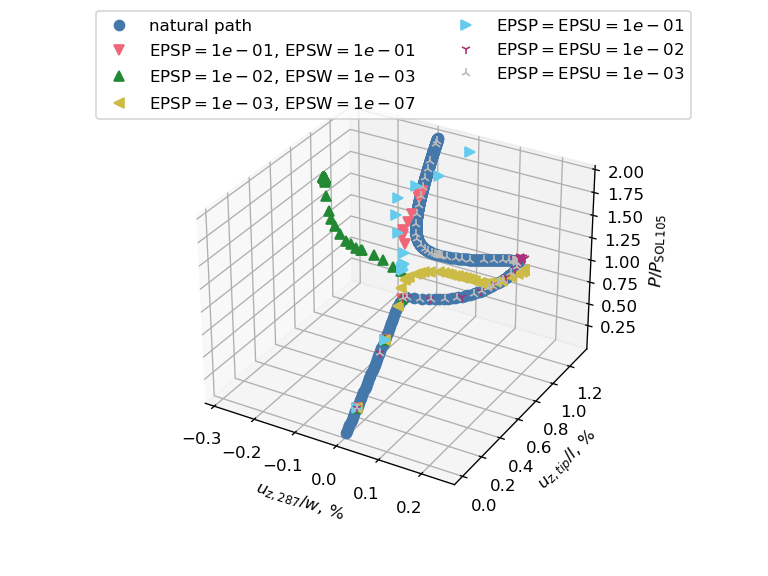

In [50]:
# Define error tolerances
load_displacement_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]

# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Run analysis and plot load-displacement for each set of load and work convergence tolerances
box_beam_bdf.nlparms[coarse_nlparm_id].conv = 'PW'
for count, epsp in enumerate(load_displacement_tolerances):
    epsw = work_tolerances[count]
    box_beam_bdf.nlparms[coarse_nlparm_id].eps_p = epsp
    box_beam_bdf.nlparms[coarse_nlparm_id].eps_w = epsw
    input_filename = f"nonlinear_analysis_epsp{epsp:.0e}_epsw{epsw:.0e}"
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1],
                                 f"$\mathrm{{EPSP}}={epsp:.0e},\,\mathrm{{EPSW}}={epsw:.0e}$", run_flag=False)

# Run analysis and plot load-displacement for each set of load and work convergence tolerances
box_beam_bdf.nlparms[coarse_nlparm_id].conv = 'PU'
for count, tol in enumerate(load_displacement_tolerances):
    box_beam_bdf.nlparms[coarse_nlparm_id].eps_p = tol
    box_beam_bdf.nlparms[coarse_nlparm_id].eps_u = tol
    input_filename = f"nonlinear_analysis_epsp{tol:.0e}_epsu{tol:.0e}"
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1 + len(load_displacement_tolerances)],
                                 f"$\mathrm{{EPSP}}=\mathrm{{EPSU}}={tol:.0e}$", run_flag=False)

# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2)
plt.show()

Work in progress.


### Initial load increment <a name="initial-load-increment"></a>

Now we consider three different values of initial load increment:
- $\Delta\mu^1=0.5$;
- $\Delta\mu^1=0.1$ (default);
- $\Delta\mu^1=0.01$.

Nastran job nonlinear_analysis_initial_load_increment_5e-01.bdf completed
Wall time: 1424.0 s


Nastran job nonlinear_analysis_initial_load_increment_1e-01.bdf completed
Wall time: 1107.0 s


Nastran job nonlinear_analysis_initial_load_increment_1e-02.bdf completed
Wall time: 1862.0 s


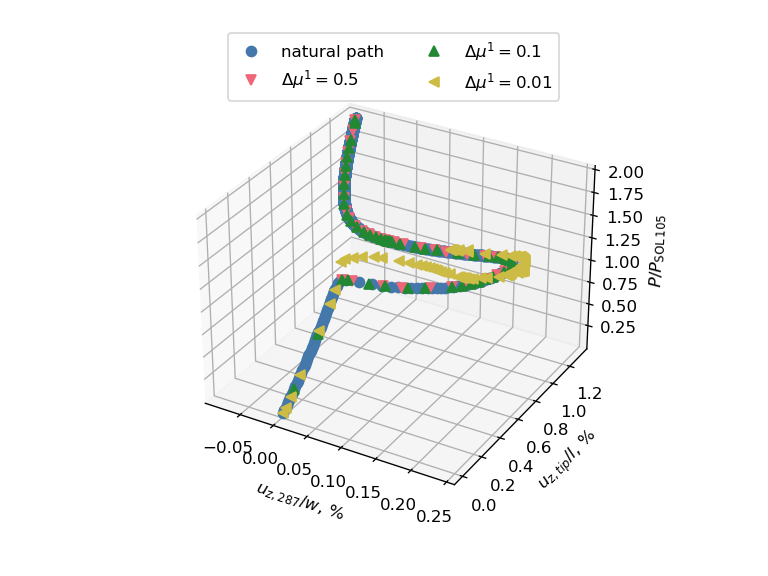

In [51]:
initial_load_increments = [.5, .1, .01]  # define list of initial load increments
box_beam_bdf.nlpcis[coarse_nlparm_id].mxinc = 100  # set maximum number of increments to 100

# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Run analysis for each set of convergence tolerances and plot load-displacement curve
for count, delta_mu_1 in enumerate(initial_load_increments):
    box_beam_bdf.nlparms[coarse_nlparm_id].ninc = round(1/delta_mu_1)
    input_filename = f"nonlinear_analysis_initial_load_increment_{delta_mu_1:.0e}"
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1], f"$\Delta\mu^1={delta_mu_1:.9g}$",
                                 run_flag=False)

# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=2)
plt.show()

### Desired number of iterations <a name="desiter"></a>

Now we investigate the influence of the desired number of iterations, using the following values:
- $I_d=20$;
- $I_d=12$ (default);
- $I_d=5$.

Nastran job nonlinear_analysis_initial_load_increment1e-01_desiter20.bdf completed
Wall time: 3127.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-01_desiter12.bdf completed
Wall time: 1223.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-01_desiter5.bdf completed
Wall time: 410.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-02_desiter20.bdf completed
Wall time: 1887.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-02_desiter12.bdf completed
Wall time: 2343.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-02_desiter5.bdf completed
Wall time: 1884.0 s


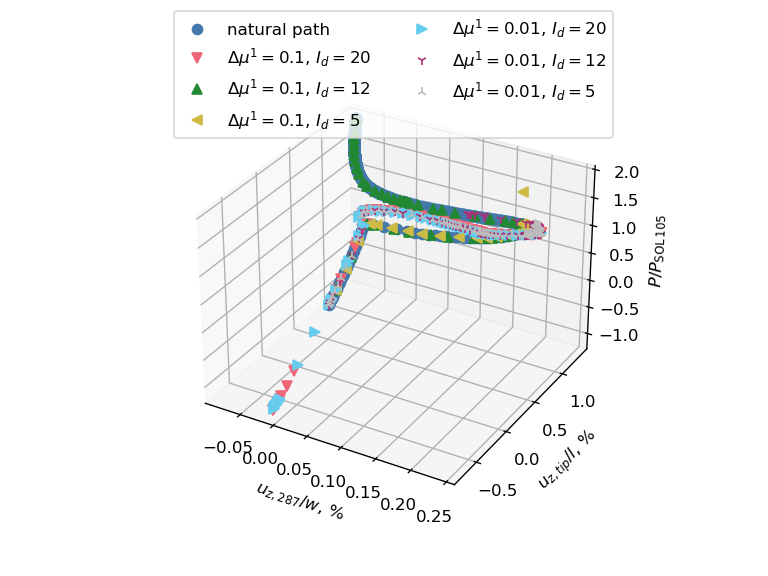

In [52]:
# Define error tolerances
no_desired_iterations = [20, 12, 5]  # define list of desired numbers of iterations

# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Run analysis and plot load-displacement for each desired number of iterations
delta_mu_1 = .1
box_beam_bdf.nlparms[coarse_nlparm_id].ninc = round(1/delta_mu_1)
for count, desiter in enumerate(no_desired_iterations):
    box_beam_bdf.nlpcis[coarse_nlparm_id].desiter = desiter
    input_filename = f"nonlinear_analysis_initial_load_increment{delta_mu_1:.0e}_desiter{desiter:d}"
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1],
                                 f"$\Delta\mu^1={delta_mu_1:.9g},\,I_d={desiter:d}$", run_flag=False)

# Run analysis and plot load-displacement for each desired number of iterations
delta_mu_1 = .01
box_beam_bdf.nlparms[coarse_nlparm_id].ninc = round(1/delta_mu_1)
for count, desiter in enumerate(no_desired_iterations):
    box_beam_bdf.nlpcis[coarse_nlparm_id].desiter = desiter
    input_filename = f"nonlinear_analysis_initial_load_increment{delta_mu_1:.0e}_desiter{desiter:d}"
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1 + len(no_desired_iterations)],
                                 f"$\Delta\mu^1={delta_mu_1:.9g},\,I_d={desiter:d}$", run_flag=False)

# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2)
plt.show()

In [53]:
box_beam_bdf.nlpcis[coarse_nlparm_id].desiter = 12

### Minimum allowable arc-length adjustment ratio <a name="minalr"></a>

Next, we assess the effect of the minimum allowable arc-length adjustment ratio, investigating three values:
- $MINALR=0.9$;
- $MINALR=0.25$ (default);
- $MINALR=0.01$.

Nastran job nonlinear_analysis_initial_load_increment1e-01_minalr0_9.bdf completed
Wall time: 1238.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-01_minalr0_25.bdf completed
Wall time: 1135.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-01_minalr0_01.bdf completed
Wall time: 1132.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-02_minalr0_9.bdf completed
Wall time: 2089.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-02_minalr0_25.bdf completed
Wall time: 2068.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-02_minalr0_01.bdf completed
Wall time: 2086.0 s


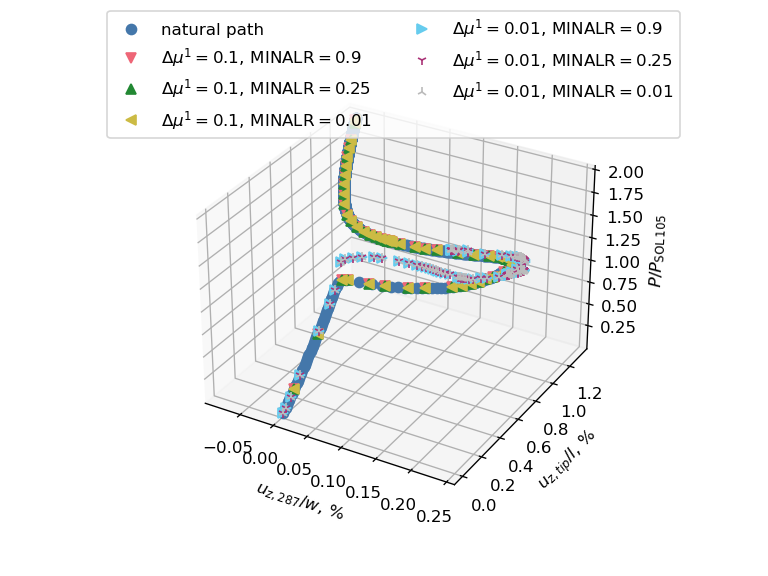

In [54]:
min_arclength_adjustment_ratios = [.9, .25, .01]  # define list of minimum allowable arc-length adjustment ratios

# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Run analysis and plot load-displacement for each desired number of iterations
delta_mu_1 = .1
box_beam_bdf.nlparms[coarse_nlparm_id].ninc = round(1/delta_mu_1)
for count, minalr in enumerate(min_arclength_adjustment_ratios):
    box_beam_bdf.nlpcis[coarse_nlparm_id].minalr = minalr
    input_filename = f"nonlinear_analysis_initial_load_increment{delta_mu_1:.0e}_minalr{minalr:.9g}".replace('.','_')
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1],
                                 f"$\Delta\mu^1={delta_mu_1:.9g},\,\mathrm{{MINALR}}={minalr:.9g}$", run_flag=False)

# Run analysis and plot load-displacement for each desired number of iterations
delta_mu_1 = .01
box_beam_bdf.nlparms[coarse_nlparm_id].ninc = round(1/delta_mu_1)
for count, minalr in enumerate(min_arclength_adjustment_ratios):
    box_beam_bdf.nlpcis[coarse_nlparm_id].minalr = minalr
    input_filename = f"nonlinear_analysis_initial_load_increment{delta_mu_1:.0e}_minalr{minalr:.9g}".replace('.','_')
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1 + len(min_arclength_adjustment_ratios)],
                                 f"$\Delta\mu^1={delta_mu_1:.9g},\,\mathrm{{MINALR}}={minalr:.9g}$", run_flag=False)

# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2)
plt.show()

In [55]:
box_beam_bdf.nlpcis[coarse_nlparm_id].minalr = .25

### Maximum allowable arc-length adjustment ratio <a name="maxalr"></a>

Finally, we consider three different maximum allowable arc-length adjustment ratios:
- $MAXALR=10$;
- $MAXALR=4$ (default);
- $MAXALR=1.01$;
- $MAXALR=1.0001$.

Before running the analyses, we increase the maximum number of allowed increments in each subcase to 200, in order to avoid the solver to stop the analysis before reaching the desired applied load.

Nastran job nonlinear_analysis_initial_load_increment1e-01_maxalr8.bdf completed
Wall time: 1184.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-01_maxalr4.bdf completed
Wall time: 1023.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-01_maxalr2.bdf completed
Wall time: 1217.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-02_maxalr8.bdf completed
Wall time: 3583.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-02_maxalr4.bdf completed
Wall time: 3846.0 s


Nastran job nonlinear_analysis_initial_load_increment1e-02_maxalr2.bdf completed
Wall time: 2988.0 s


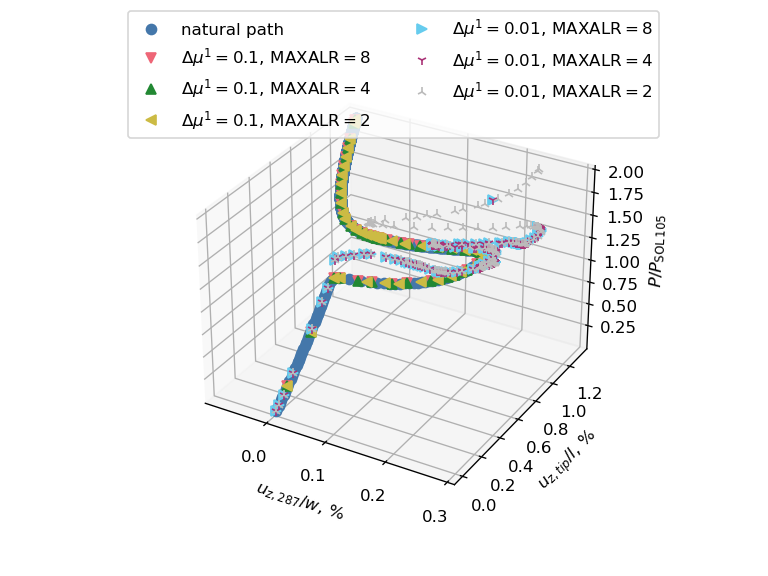

In [56]:
max_arclength_adjustment_ratios = [8., 4., 2.]  # define list of minimum allowable arc-length adjustment ratios

# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Run analysis and plot load-displacement for each desired number of iterations
delta_mu_1 = .1
box_beam_bdf.nlparms[coarse_nlparm_id].ninc = round(1/delta_mu_1)
for count, maxalr in enumerate(max_arclength_adjustment_ratios):
    box_beam_bdf.nlpcis[coarse_nlparm_id].maxalr = maxalr
    input_filename = f"nonlinear_analysis_initial_load_increment{delta_mu_1:.0e}_maxalr{maxalr:.9g}".replace('.','_')
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1],
                                 f"$\Delta\mu^1={delta_mu_1:.9g},\,\mathrm{{MAXALR}}={maxalr:.9g}$", run_flag=False)

# Run analysis and plot load-displacement for each desired number of iterations
delta_mu_1 = .01
box_beam_bdf.nlparms[coarse_nlparm_id].ninc = round(1/delta_mu_1)
for count, maxalr in enumerate(max_arclength_adjustment_ratios):
    box_beam_bdf.nlpcis[coarse_nlparm_id].maxalr = maxalr
    input_filename = f"nonlinear_analysis_initial_load_increment{delta_mu_1:.0e}_maxalr{maxalr:.9g}".replace('.','_')
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1 + len(max_arclength_adjustment_ratios)],
                                 f"$\Delta\mu^1={delta_mu_1:.9g},\,\mathrm{{MAXALR}}={maxalr:.9g}$", run_flag=False)

# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2)
plt.show()